# Preparazione e costruzione delle serie temporali
**dataset:** /air_quality_health_dataset.csv
si carica e in seguito in questa fase si esplora e si fa un preprocessing dei dati del dataset 
- importo del dataset con riduzione delle colonne per concntrasi solo sulle caratteirtiche piu consone allo studio
- conversione in datetime e ordinamento del dataset
- Aggregazione dei dati con frequenza costante tramite resample (settimanale)

**obiettivo:** ottenere serie regolare, completa e pronta per modelling


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import pmdarima as pm


# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Statistical tests
from scipy import stats
from scipy.stats import jarque_bera, shapiro
# Configurazione visualizzazioni
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

In [2]:
df = pd.read_csv('air_quality_health_dataset.csv')
df_reduced = df[['date', 'region', 'PM2.5', 'NO2', 'O3', 'temperature', 'humidity','wind_speed', 'respiratory_admissions']]
df=df_reduced
df.head()


,date,region,PM2.5,NO2,O3,temperature,humidity,wind_speed,respiratory_admissions
0,2020-01-01,East,31.382887,47.654022,32.574682,37.555663,20.542799,5.204995,11
1,2020-01-02,Central,47.094225,50.734127,23.749138,24.900342,27.308785,6.235446,13
2,2020-01-03,East,53.795917,44.986899,35.530851,23.437165,80.055977,5.673999,3
3,2020-01-04,West,88.315315,20.575023,25.277106,22.388200,25.929988,8.496463,6
4,2020-01-05,South,68.348297,38.445776,35.996440,26.881835,34.946343,1.184104,8


In [3]:
df.tail()

,date,region,PM2.5,NO2,O3,temperature,humidity,wind_speed,respiratory_admissions
2995,2020-03-16,West,62.572040,28.188065,26.473666,30.823665,39.543222,3.582931,8
2996,2020-03-17,Central,77.289722,39.271776,41.684453,28.343987,21.611366,7.660774,7
2997,2020-03-18,East,41.738943,48.380141,39.295269,26.050318,80.183686,10.214574,10
2998,2020-03-19,Central,67.019256,38.993041,31.667658,26.028273,46.396429,6.898789,11
2999,2020-03-20,South,42.445789,30.536862,12.106839,27.691147,43.062449,1.228877,15


non ci sono valori nulli presenti nel datate

In [4]:
# Dataset information
print(f"Dataset shape: {df.shape}\n")
df.info()

Dataset shape: (3000, 9)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    3000 non-null   object 
 1   region                  3000 non-null   object 
 2   PM2.5                   3000 non-null   float64
 3   NO2                     3000 non-null   float64
 4   O3                      3000 non-null   float64
 5   temperature             3000 non-null   float64
 6   humidity                3000 non-null   float64
 7   wind_speed              3000 non-null   float64
 8   respiratory_admissions  3000 non-null   int64  
dtypes: float64(6), int64(1), object(2)
memory usage: 211.1+ KB


In [5]:
# Numerical feature summary
df.describe()

,PM2.5,NO2,O3,temperature,humidity,wind_speed,respiratory_admissions
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,59.426348,39.789545,29.970248,24.950278,55.064617,7.445412,9.923333
std,15.132393,9.834362,8.026695,4.927167,20.336369,4.296773,3.161031
min,12.349443,0.775997,0.000000,6.724567,20.004725,0.000083,1.000000
25%,49.311574,33.279636,24.590968,21.484840,36.896629,3.705526,8.000000
50%,59.665656,39.771488,29.940792,24.947689,55.411279,7.479178,10.000000
75%,69.579966,46.332485,35.551940,28.309660,72.455010,11.083132,12.000000
max,108.646395,73.777682,61.538648,43.056750,89.978805,14.996841,23.000000


In [6]:
# Check for duplicate rows
df[df.duplicated()]

,date,region,PM2.5,NO2,O3,temperature,humidity,wind_speed,respiratory_admissions


In [7]:
print(df['region'].value_counts())

region
East       635
South      619
North      586
West       583
Central    577
Name: count, dtype: int64


analisi relativa ad un unica regione

In [8]:
df_east = df[df['region'] == 'East']

df_east.head()

,date,region,PM2.5,NO2,O3,temperature,humidity,wind_speed,respiratory_admissions
0,2020-01-01,East,31.382887,47.654022,32.574682,37.555663,20.542799,5.204995,11
2,2020-01-03,East,53.795917,44.986899,35.530851,23.437165,80.055977,5.673999,3
9,2020-01-10,East,52.933130,51.480909,40.945512,35.152729,34.532796,9.904895,11
12,2020-01-13,East,40.692546,14.791530,43.229082,20.291911,23.696398,1.489816,11
26,2020-01-27,East,62.856358,35.634851,32.339874,23.681505,69.055426,8.702339,9


In [9]:
df_east['date'] = pd.to_datetime(df_east['date'])

df_east.set_index('date', inplace=True)
df_east.head()

C:\Users\Asus\AppData\Local\Temp\ipykernel_19096\3526835639.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_east['date'] = pd.to_datetime(df_east['date'])


,region,PM2.5,NO2,O3,temperature,humidity,wind_speed,respiratory_admissions
date,,,,,,,,
2020-01-01,East,31.382887,47.654022,32.574682,37.555663,20.542799,5.204995,11
2020-01-03,East,53.795917,44.986899,35.530851,23.437165,80.055977,5.673999,3
2020-01-10,East,52.933130,51.480909,40.945512,35.152729,34.532796,9.904895,11
2020-01-13,East,40.692546,14.791530,43.229082,20.291911,23.696398,1.489816,11
2020-01-27,East,62.856358,35.634851,32.339874,23.681505,69.055426,8.702339,9


ordinamento del dataset nella colonna date

In [10]:
df_east = df_east.sort_index()

In [11]:

# Definiamo come trattare ogni colonna 
aggregation_logic = {
    'PM2.5': 'mean',
    'NO2': 'mean',
    'O3': 'mean',
    'temperature': 'mean',
    'humidity': 'mean',
    'wind_speed': 'mean',
    'respiratory_admissions': 'sum' 
}

# Eseguiamo il resample settimanale
df_weekly = df_east.resample('W').agg(aggregation_logic)

print(df_weekly.head())

                PM2.5        NO2         O3  temperature   humidity  \
date                                                                  
2020-01-05  59.384035  36.761954  31.036800    26.866985  52.120856   
2020-01-12  57.604828  44.890266  33.386451    24.287743  52.805481   
2020-01-19  56.847925  33.771576  32.032120    21.802331  40.455749   
2020-01-26  62.029037  43.802169  30.755770    22.198627  57.556851   
2020-02-02  59.843503  35.706730  32.199352    26.193452  50.902530   

            wind_speed  respiratory_admissions  
date                                            
2020-01-05    5.320074                      41  
2020-01-12    9.054286                     125  
2020-01-19    5.082848                      67  
2020-01-26    6.129686                      84  
2020-02-02    6.555219                      88  


In [12]:
df_weekly.isnull().sum()

PM2.5                     0
NO2                       0
O3                        0
temperature               0
humidity                  0
wind_speed                0
respiratory_admissions    0
dtype: int64

# Analisi esplorativa del dataset(EDA)

- analisi standard per vedere i limiti del dataset 
- analisi per mezzo di grafici

calcolare media varianza valori massimi e minimi

In [13]:
# Creiamo le colonne per Anno e Mese
df_east['year'] = df_east.index.year
df_east['month'] = df_east.index.month

# Definiamo una funzione per mappare i mesi alle stagioni (Inverno, Primavera, Estate, Autunno)
def get_season(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Spring'
    elif month in [6, 7, 8]: return 'Summer'
    else: return 'Autumn'

df_east['season'] = df_east['month'].apply(get_season)

In [14]:
# Selezioniamo le colonne numeriche di interesse
cols_to_analyze = ['PM2.5', 'NO2', 'O3', 'temperature', 'humidity','wind_speed', 'respiratory_admissions']

print("=== Statistiche descrittive per ANNO (Formato Verticale) ===")

# 1. Calcoliamo le statistiche
yearly_stats = df_east.groupby('year')[cols_to_analyze].agg(['mean', 'var', 'min', 'max'])

yearly_stats_vertical = yearly_stats.stack(level=0).round(2)

print(yearly_stats_vertical)

=== Statistiche descrittive per ANNO (Formato Verticale) ===
                              mean     var    min     max
year                                                     
2020 NO2                     39.80  100.84  10.91   72.88
     O3                      31.04   62.20   5.92   52.58
     PM2.5                   59.19  224.67  16.29  104.03
     humidity                54.63  419.40  20.39   89.89
     respiratory_admissions  10.01    9.37   3.00   19.00
     temperature             25.10   25.17  10.77   37.56
     wind_speed               7.30   18.05   0.01   14.92
2021 NO2                     39.43   89.91   6.24   65.30
     O3                      30.67   70.08   8.62   58.82
     PM2.5                   59.81  242.17  14.89  108.65
     humidity                54.86  421.33  20.32   89.70
     respiratory_admissions   9.76    9.86   3.00   21.00
     temperature             24.79   24.66  13.87   39.99
     wind_speed               7.61   20.54   0.03   14.97


C:\Users\Asus\AppData\Local\Temp\ipykernel_19096\3437357385.py:9: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  yearly_stats_vertical = yearly_stats.stack(level=0).round(2)


In [15]:
print("\n=== Statistiche descrittive per STAGIONE (Formato Verticale) ===")

# 1. Calcoliamo le statistiche come prima
seasonal_stats = df_east.groupby('season')[cols_to_analyze].agg(['mean', 'var', 'min', 'max'])

# 2. Portiamo le variabili a capo (stack) e arrotondiamo per leggibilità
seasonal_stats_vertical = seasonal_stats.stack(level=0).round(2)

# 3. Opzionale: rinominiamo l'indice dello stack per chiarezza
seasonal_stats_vertical.index.names = ['Stagione', 'Variabile']

print(seasonal_stats_vertical)


=== Statistiche descrittive per STAGIONE (Formato Verticale) ===
                                  mean     var    min     max
Stagione Variabile                                           
Autumn   NO2                     40.81   94.06  10.91   72.88
         O3                      30.83   57.40  13.35   58.82
         PM2.5                   59.83  192.00  25.20   92.55
         humidity                53.01  423.40  20.84   89.54
         respiratory_admissions   9.83   10.18   3.00   21.00
         temperature             24.97   23.62  11.65   37.52
         wind_speed               7.36   20.40   0.01   14.95
Spring   NO2                     38.80   98.09  10.27   61.77
         O3                      31.90   57.54   5.92   52.58
         PM2.5                   60.11  250.03  14.89   91.27
         humidity                58.02  410.86  20.32   89.57
         respiratory_admissions   9.85   10.53   3.00   21.00
         temperature             25.47   28.32  13.43   37.83
    

C:\Users\Asus\AppData\Local\Temp\ipykernel_19096\3625588913.py:7: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  seasonal_stats_vertical = seasonal_stats.stack(level=0).round(2)


**Media nel tempo**
I livelli medi di PM2.5 e temperatura risultano complessivamente stabili nel periodo analizzato, senza evidenti trend di lungo periodo. Tuttavia, i ricoveri respiratori mostrano variazioni locali della media, con periodi caratterizzati da valori mediamente più elevati.

**Varianza nel tempo**
L’ampiezza delle fluttuazioni non è uniforme: per il PM2.5 e i ricoveri respiratori si osservano fasi con maggiore dispersione dei valori, alternate a periodi più stabili. Questo suggerisce una varianza non costante nel tempo.

**Stagionalità**
È presente una componente stagionale, più evidente nei ricoveri respiratori, con picchi ricorrenti nei mesi invernali. Le temperature mostrano una stagionalità regolare, mentre il PM2.5 presenta episodi estremi distribuiti lungo l’anno.

**Valori estremi**
Si osservano picchi significativi, in particolare per il PM2.5 e i ricoveri respiratori, che indicano la presenza di eventi episodici potenzialmente rilevanti dal punto di vista sanitario.

In sintesi, le serie temporali non mostrano trend marcati ma presentano variabilità non costante e componenti stagionali, suggerendo una possibile non stazionarietà. Per analisi successive, risulta quindi opportuno valutare tecniche di decomposizione o trasformazione delle serie.


────────────────────────────────────────────────────────────────────────────────
SCATTER PLOTS: PM2.5 vs Ricoveri (Lag 0, 1, 2)
────────────────────────────────────────────────────────────────────────────────



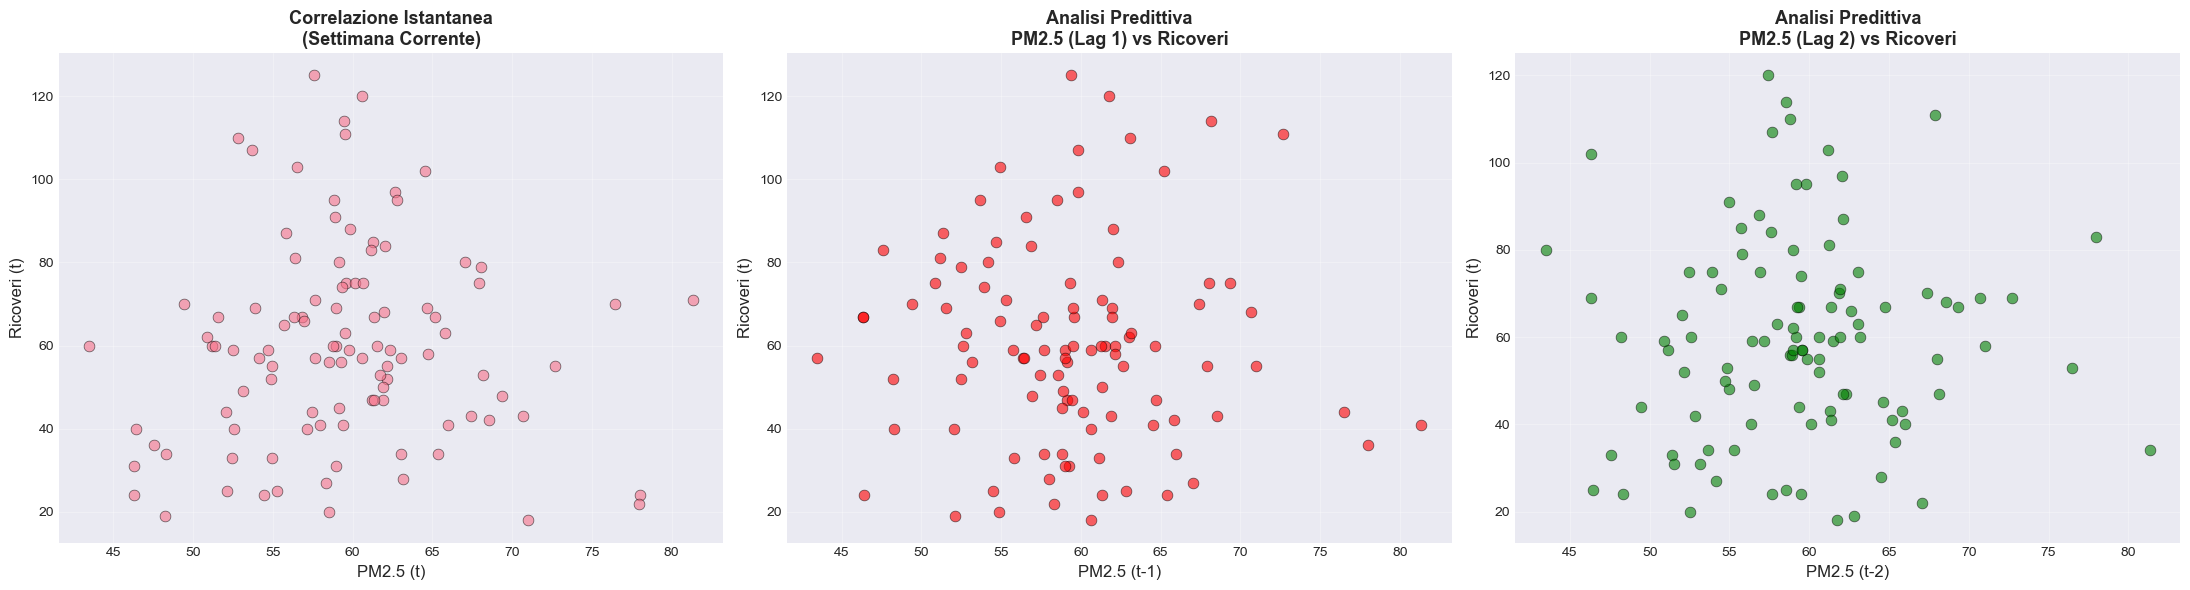

In [16]:
print("\n" + "─"*80)
print("SCATTER PLOTS: PM2.5 vs Ricoveri (Lag 0, 1, 2)")
print("─"*80 + "\n")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 6))

# Lag 0
sns.scatterplot(data=df_weekly, x='PM2.5', y='respiratory_admissions', 
                alpha=0.6, ax=ax1, s=60, edgecolor='black', linewidth=0.5)
ax1.set_title('Correlazione Istantanea\n(Settimana Corrente)', fontsize=13, fontweight='bold')
ax1.set_xlabel('PM2.5 (t)', fontsize=12)
ax1.set_ylabel('Ricoveri (t)', fontsize=12)
ax1.grid(True, alpha=0.3)

# Lag 1
sns.scatterplot(x=df_weekly['PM2.5'].shift(1), y=df_weekly['respiratory_admissions'], 
                color='red', alpha=0.6, ax=ax2, s=60, edgecolor='black', linewidth=0.5)
ax2.set_title('Analisi Predittiva\nPM2.5 (Lag 1) vs Ricoveri', fontsize=13, fontweight='bold')
ax2.set_xlabel('PM2.5 (t-1)', fontsize=12)
ax2.set_ylabel('Ricoveri (t)', fontsize=12)
ax2.grid(True, alpha=0.3)

# Lag 2
sns.scatterplot(x=df_weekly['PM2.5'].shift(2), y=df_weekly['respiratory_admissions'], 
                color='green', alpha=0.6, ax=ax3, s=60, edgecolor='black', linewidth=0.5)
ax3.set_title('Analisi Predittiva\nPM2.5 (Lag 2) vs Ricoveri', fontsize=13, fontweight='bold')
ax3.set_xlabel('PM2.5 (t-2)', fontsize=12)
ax3.set_ylabel('Ricoveri (t)', fontsize=12)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


L’analisi esplorativa non evidenzia una relazione forte tra PM2.5 e ricoveri respiratori nella stessa settimana. Introducendo ritardi temporali, in particolare a una e due settimane, emerge un segnale più coerente, suggerendo un possibile effetto ritardato e cumulativo dell’esposizione al PM2.5. La distribuzione dei ricoveri è asimmetrica e non normale, mentre l’analisi delle differenze indica che la serie può essere resa stazionaria. Nel complesso, l’effetto del PM2.5 risulta debole e richiede modelli dinamici con lag e controllo della struttura temporale.


────────────────────────────────────────────────────────────────────────────────
SCATTER PLOTS: Temperatura vs Ricoveri (Lag 0, 1, 2)
────────────────────────────────────────────────────────────────────────────────



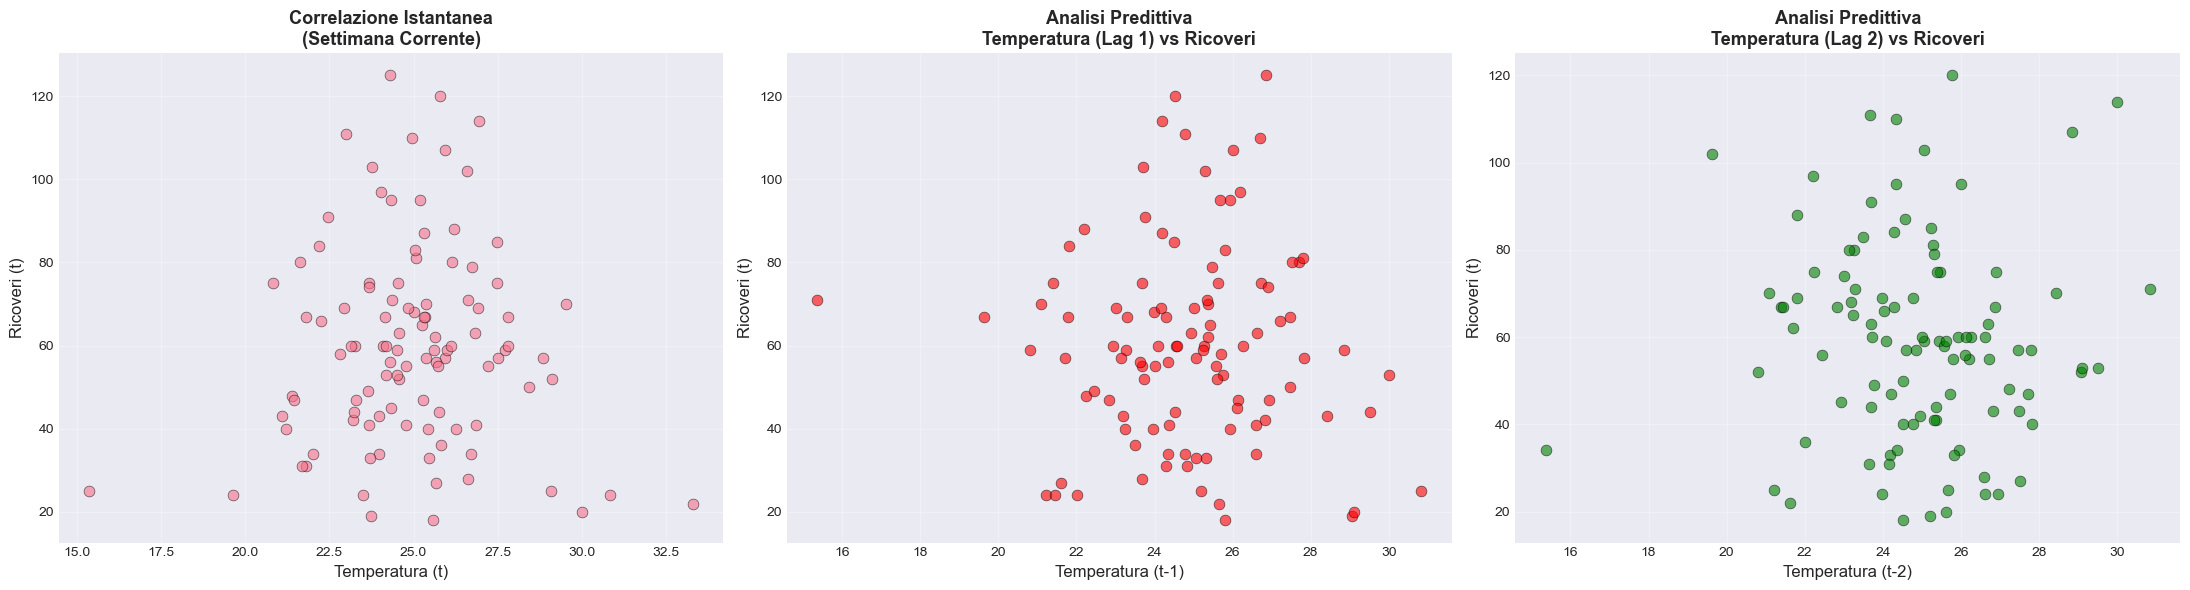

In [17]:
print("\n" + "─"*80)
print("SCATTER PLOTS: Temperatura vs Ricoveri (Lag 0, 1, 2)")
print("─"*80 + "\n")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 6))

# Lag 0
sns.scatterplot(data=df_weekly, x='temperature', y='respiratory_admissions', 
                alpha=0.6, ax=ax1, s=60, edgecolor='black', linewidth=0.5)
ax1.set_title('Correlazione Istantanea\n(Settimana Corrente)', fontsize=13, fontweight='bold')
ax1.set_xlabel('Temperatura (t)', fontsize=12)
ax1.set_ylabel('Ricoveri (t)', fontsize=12)
ax1.grid(True, alpha=0.3)

# Lag 1
sns.scatterplot(x=df_weekly['temperature'].shift(1), y=df_weekly['respiratory_admissions'], 
                color='red', alpha=0.6, ax=ax2, s=60, edgecolor='black', linewidth=0.5)
ax2.set_title('Analisi Predittiva\nTemperatura (Lag 1) vs Ricoveri', fontsize=13, fontweight='bold')
ax2.set_xlabel('Temperatura (t-1)', fontsize=12)
ax2.set_ylabel('Ricoveri (t)', fontsize=12)
ax2.grid(True, alpha=0.3)

# Lag 2
sns.scatterplot(x=df_weekly['temperature'].shift(2), y=df_weekly['respiratory_admissions'], 
                color='green', alpha=0.6, ax=ax3, s=60, edgecolor='black', linewidth=0.5)
ax3.set_title('Analisi Predittiva\nTemperatura (Lag 2) vs Ricoveri', fontsize=13, fontweight='bold')
ax3.set_xlabel('Temperatura (t-2)', fontsize=12)
ax3.set_ylabel('Ricoveri (t)', fontsize=12)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



────────────────────────────────────────────────────────────────────────────────
DISTRIBUZIONE RICOVERI: Grezzi vs Differenziati
────────────────────────────────────────────────────────────────────────────────



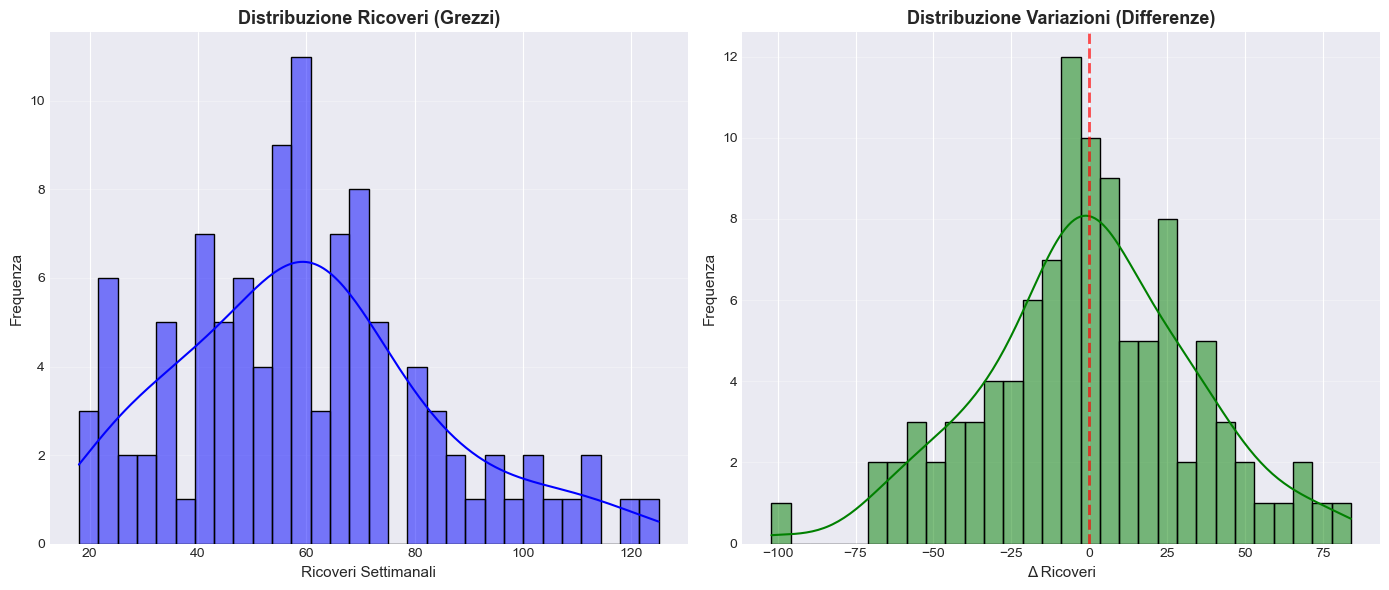

💡 La distribuzione delle differenze è più simmetrica → serie può essere resa stazionaria



In [18]:
print("\n" + "─"*80)
print("DISTRIBUZIONE RICOVERI: Grezzi vs Differenziati")
print("─"*80 + "\n")

plt.figure(figsize=(14, 6))

# Istogramma grezzi
plt.subplot(1, 2, 1)
sns.histplot(df_weekly['respiratory_admissions'], kde=True, color='blue', bins=30)
plt.title('Distribuzione Ricoveri (Grezzi)', fontsize=13, fontweight='bold')
plt.xlabel('Ricoveri Settimanali', fontsize=11)
plt.ylabel('Frequenza', fontsize=11)
plt.grid(True, alpha=0.3, axis='y')

# Istogramma differenze
plt.subplot(1, 2, 2)
diff_admissions = df_weekly['respiratory_admissions'].diff().dropna()
sns.histplot(diff_admissions, kde=True, color='green', bins=30)
plt.title('Distribuzione Variazioni (Differenze)', fontsize=13, fontweight='bold')
plt.xlabel('Δ Ricoveri', fontsize=11)
plt.ylabel('Frequenza', fontsize=11)
plt.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.7)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("💡 La distribuzione delle differenze è più simmetrica → serie può essere resa stazionaria\n")


Gli istogrammi mostrano che i ricoveri respiratori non sono normalmente distribuiti in livello, mentre le differenze presentano una distribuzione più simmetrica, indicando che la serie può essere resa stazionaria tramite differenziazione.

────────────────────────────────────────────────────────────────────────────────
VISUALIZZAZIONE SERIE TEMPORALE RICOVERI
────────────────────────────────────────────────────────────────────────────────



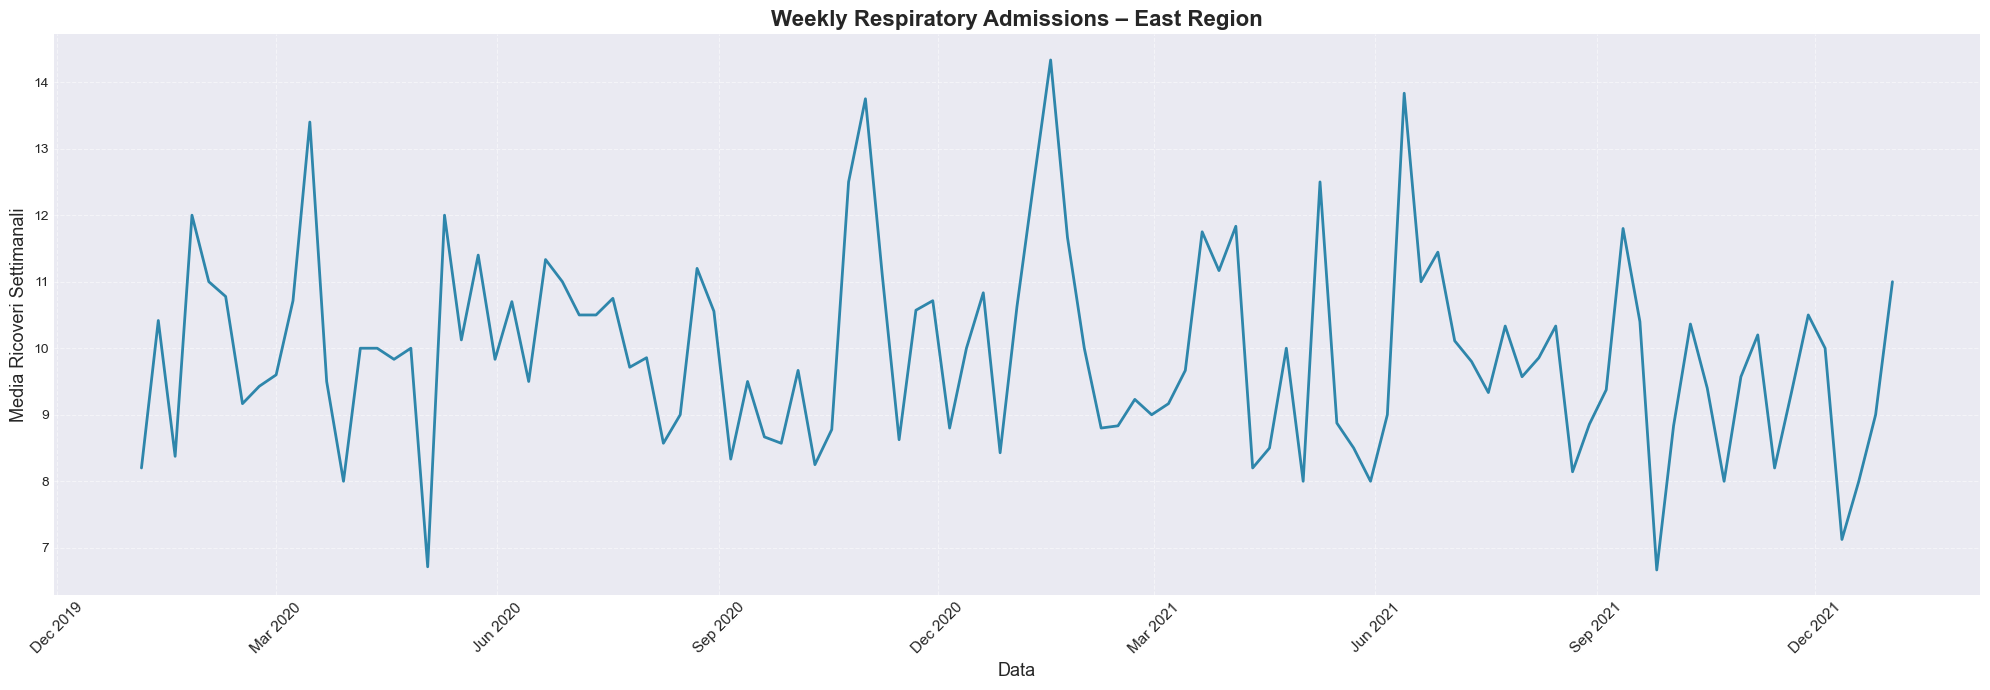

In [19]:
print("─"*80)
print("VISUALIZZAZIONE SERIE TEMPORALE RICOVERI")
print("─"*80 + "\n")

weekly_resp = df_east['respiratory_admissions'].resample('W').mean()

plt.figure(figsize=(20, 7))
plt.plot(weekly_resp.index, weekly_resp, linewidth=2, color='#2E86AB')

# Formattazione asse X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45, fontsize=11)

plt.title('Weekly Respiratory Admissions – East Region', fontsize=16, fontweight='bold')
plt.xlabel('Data', fontsize=13)
plt.ylabel('Media Ricoveri Settimanali', fontsize=13)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

come si puo notare dai grafici l'adamento dei due parametri considerati non sono stazionari
- media non costante nel tempo
- varianza non costante nel tempo
- valori piu contenuti in certi intervalli

## Scomposizione serie temporale
decomposizione stagiaonale per separare: 
- trend di lungo periodo
- stagionalita
- componente residua


FASE 4: DECOMPOSIZIONE STAGIONALE



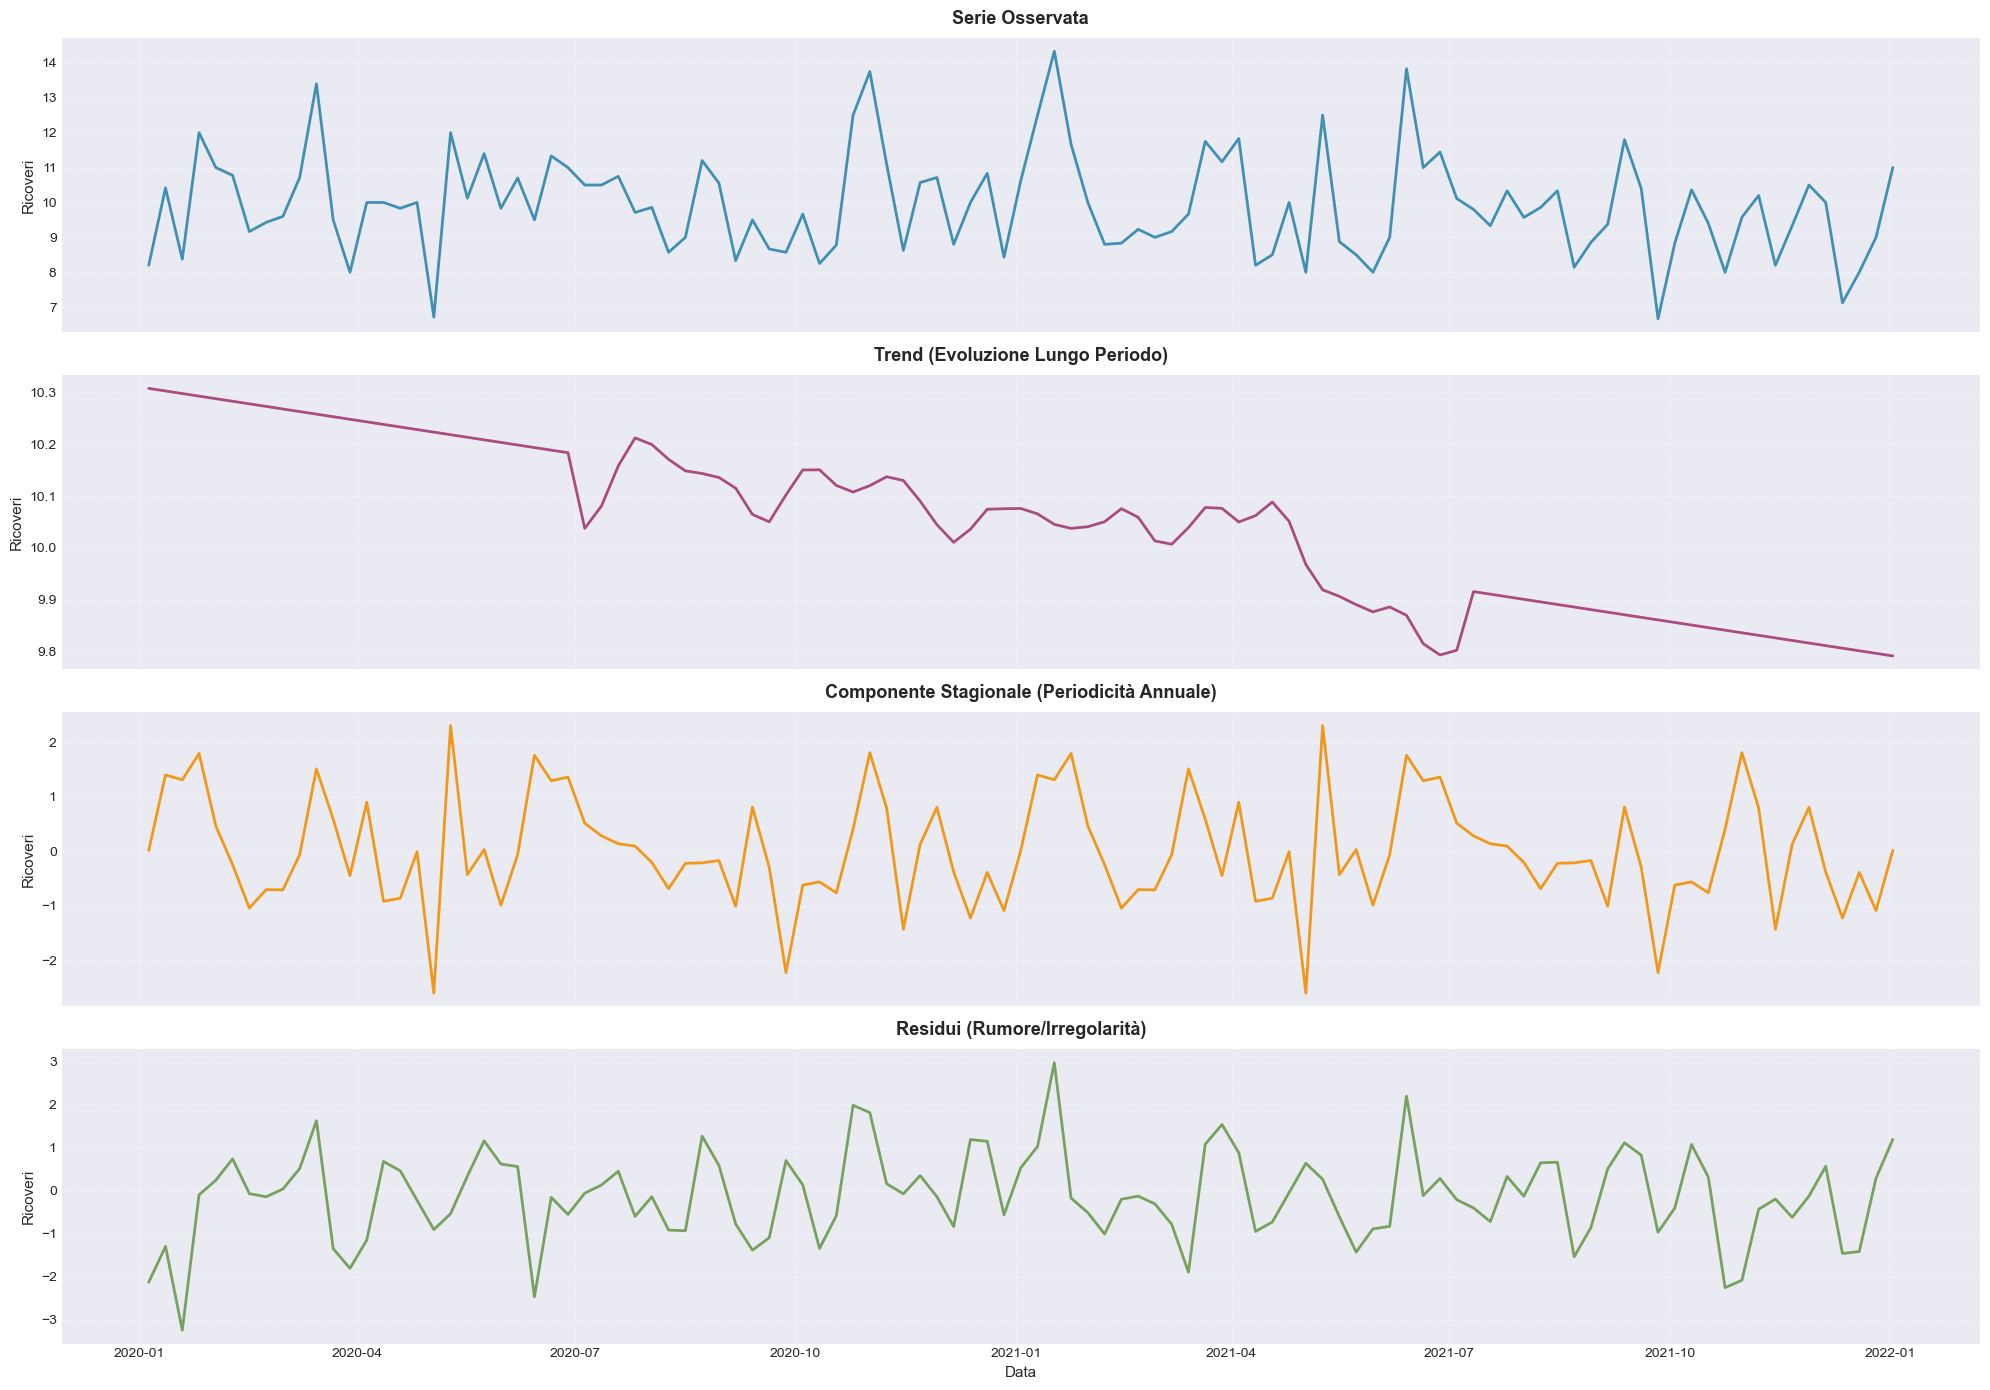

📊 Forza componente stagionale: 0.486 (0=assente, 1=molto forte)



In [20]:
print("\n" + "="*80)
print("FASE 4: DECOMPOSIZIONE STAGIONALE")
print("="*80 + "\n")

weekly_pm25 = df_east['respiratory_admissions'].resample('W').mean().dropna()

decomposition = seasonal_decompose(
    weekly_pm25, 
    model='additive', 
    period=52,
    extrapolate_trend='freq'
)

fig, axes = plt.subplots(4, 1, figsize=(20, 14), sharex=True)

components = [
    (decomposition.observed, 'Serie Osservata', '#2E86AB'),
    (decomposition.trend, 'Trend (Evoluzione Lungo Periodo)', '#A23B72'),
    (decomposition.seasonal, 'Componente Stagionale (Periodicità Annuale)', '#F18F01'),
    (decomposition.resid, 'Residui (Rumore/Irregolarità)', '#6A994E')
]

for i, (data, title, color) in enumerate(components):
    axes[i].plot(data, color=color, linewidth=2, alpha=0.9)
    axes[i].set_title(title, fontsize=13, fontweight='bold', pad=10)
    axes[i].set_ylabel('Ricoveri', fontsize=11)
    axes[i].grid(True, linestyle='--', alpha=0.4)
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

axes[3].set_xlabel('Data', fontsize=11)

plt.tight_layout()
plt.show()

# Forza stagionalità
seasonal_strength = 1 - (decomposition.resid.var() / 
                         (decomposition.seasonal + decomposition.resid).var())
print(f"📊 Forza componente stagionale: {seasonal_strength:.3f} (0=assente, 1=molto forte)\n")


- componente trend:il grrafico mostra una diminuzione nei due anni, media non costante nel tempo
- componente stagionale: il grafico mostra una peridiocità annuale, satgionalita fissa e repetitiva
- componente residuale: non appare una periodicita evidente, con residui che oscillano introno allo 0
Concludendo la serie non è stazionaria a livello, dato che presenta trend e stagionalita; quindi bisonga rendere i residui stazionari, rimuovendo il trend e la stagionalita o per mezzo di una diffrenziazzione 


Per confermare l'ipotesi effettuiamo l'adf-test, per misurare il p-value, che per serie stazionarie dovrebbe essere inferiore a 0,05

FASE 5: TEST DI STAZIONARIETÀ (ADF)


1️⃣  SERIE ORIGINALE

────────────────────────────────────────────────────────────────────────────────
TEST ADF: Ricoveri Respiratori (Originale)
────────────────────────────────────────────────────────────────────────────────
ADF Statistic:        -16.467584
p-value:              0.000000
Lags Used:            1
Observations:         633
Critical Value (1%):  -3.440723
Critical Value (5%):  -2.866117
Critical Value (10%): -2.569207

✓ Serie STAZIONARIA (p-value < 0.05)
  → Rifiutiamo H0: la serie non ha radice unitaria


2️⃣  SERIE DIFFERENZIATA (d=1)

────────────────────────────────────────────────────────────────────────────────
TEST ADF: Ricoveri Respiratori (Differenziata)
────────────────────────────────────────────────────────────────────────────────
ADF Statistic:        -9.714015
p-value:              0.000000
Lags Used:            18
Observations:         615
Critical Value (1%):  -3.441028
Critical Value (5%):  -2.866251
Critical Value 

C:\Users\Asus\AppData\Local\Temp\ipykernel_19096\3766617690.py:92: UserWarning: Glyph 8325 (\N{SUBSCRIPT FIVE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Asus\AppData\Local\Temp\ipykernel_19096\3766617690.py:92: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8325 (\N{SUBSCRIPT FIVE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


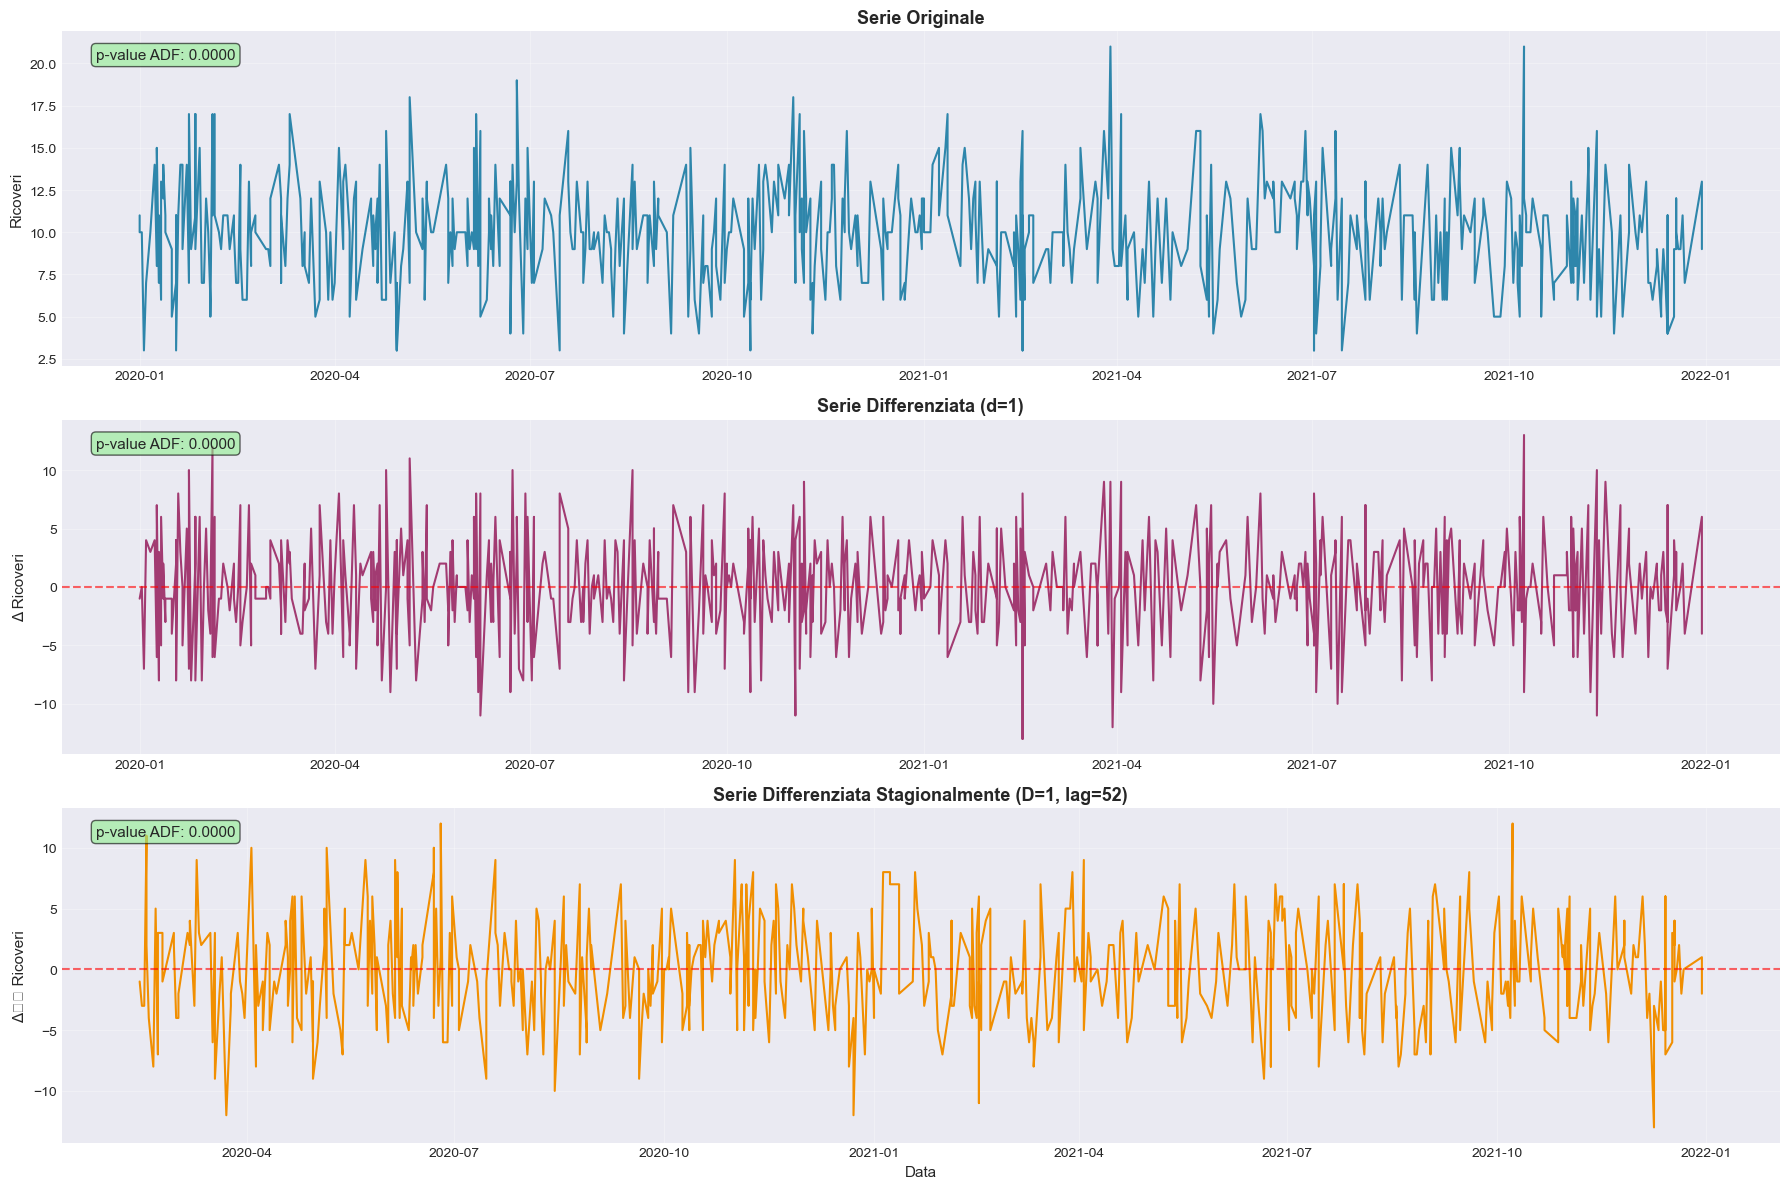

In [ ]:
print("="*80)
print("FASE 5: TEST DI STAZIONARIETÀ (ADF)")
print("="*80 + "\n")

def adf_test_report(series, title):
    """Esegue ADF test e stampa risultati formattati"""
    result = adfuller(series.dropna(), autolag='AIC')
    
    print(f"{'─'*80}")
    print(f"TEST ADF: {title}")
    print(f"{'─'*80}")
    print(f"ADF Statistic:        {result[0]:.6f}")
    print(f"p-value:              {result[1]:.6f}")
    print(f"Lags Used:            {result[2]}")
    print(f"Observations:         {result[3]}")
    print(f"Critical Value (1%):  {result[4]['1%']:.6f}")
    print(f"Critical Value (5%):  {result[4]['5%']:.6f}")
    print(f"Critical Value (10%): {result[4]['10%']:.6f}")
    
    if result[1] < 0.05:
        print(f"\n✓ Serie STAZIONARIA (p-value < 0.05)")
        print(f"  → Rifiutiamo H0: la serie non ha radice unitaria")
    else:
        print(f"\n✗ Serie NON STAZIONARIA (p-value >= 0.05)")
        print(f"  → Non possiamo rifiutare H0: probabile radice unitaria")
        print(f"  → Necessaria differenziazione")
    print()
    
    return result

# Test serie originale
print("\n1️⃣  SERIE ORIGINALE\n")
adf_original = adf_test_report(df_east['respiratory_admissions'], 
                                'Ricoveri Respiratori (Originale)')

# MIGLIORAMENTO: Test serie differenziata
print("\n2️⃣  SERIE DIFFERENZIATA (d=1)\n")
diff_series = df_east['respiratory_admissions'].diff().dropna()
adf_diff = adf_test_report(diff_series, 
                           'Ricoveri Respiratori (Differenziata)')

# MIGLIORAMENTO: Test diff stagionale
print("\n3️⃣  SERIE DIFFERENZIATA STAGIONALMENTE (D=1, lag=52)\n")
seasonal_diff = df_east['respiratory_admissions'].diff(52).dropna()
adf_seasonal = adf_test_report(seasonal_diff, 
                               'Ricoveri Respiratori (Diff. Stagionale)')

# Visualizzazione comparativa
fig, axes = plt.subplots(3, 1, figsize=(18, 12))

# Serie originale
axes[0].plot(df_east.index, df_east['respiratory_admissions'], 
            linewidth=1.5, color='#2E86AB')
axes[0].set_title('Serie Originale', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Ricoveri', fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].text(0.02, 0.95, f"p-value ADF: {adf_original[1]:.4f}", 
            transform=axes[0].transAxes, fontsize=11,
            verticalalignment='top', 
            bbox=dict(boxstyle='round', 
                     facecolor='yellow' if adf_original[1] >= 0.05 else 'lightgreen', 
                     alpha=0.6))

# Serie differenziata
axes[1].plot(diff_series.index, diff_series, linewidth=1.5, color='#A23B72')
axes[1].axhline(0, color='red', linestyle='--', alpha=0.6)
axes[1].set_title('Serie Differenziata (d=1)', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Δ Ricoveri', fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].text(0.02, 0.95, f"p-value ADF: {adf_diff[1]:.4f}", 
            transform=axes[1].transAxes, fontsize=11,
            verticalalignment='top', 
            bbox=dict(boxstyle='round', 
                     facecolor='yellow' if adf_diff[1] >= 0.05 else 'lightgreen', 
                     alpha=0.6))

# Diff stagionale
axes[2].plot(seasonal_diff.index, seasonal_diff, linewidth=1.5, color='#F18F01')
axes[2].axhline(0, color='red', linestyle='--', alpha=0.6)
axes[2].set_title('Serie Differenziata Stagionalmente (D=1, lag=52)', 
                 fontsize=13, fontweight='bold')
axes[2].set_ylabel('Δ₅₂ Ricoveri', fontsize=11)
axes[2].set_xlabel('Data', fontsize=11)
axes[2].grid(True, alpha=0.3)
axes[2].text(0.02, 0.95, f"p-value ADF: {adf_seasonal[1]:.4f}", 
            transform=axes[2].transAxes, fontsize=11,
            verticalalignment='top', 
            bbox=dict(boxstyle='round', 
                     facecolor='yellow' if adf_seasonal[1] >= 0.05 else 'lightgreen', 
                     alpha=0.6))

plt.tight_layout()
plt.show()

## Analisi dei correlogrammi  
- acf
- pacf


FASE 6: ANALISI ACF/PACF



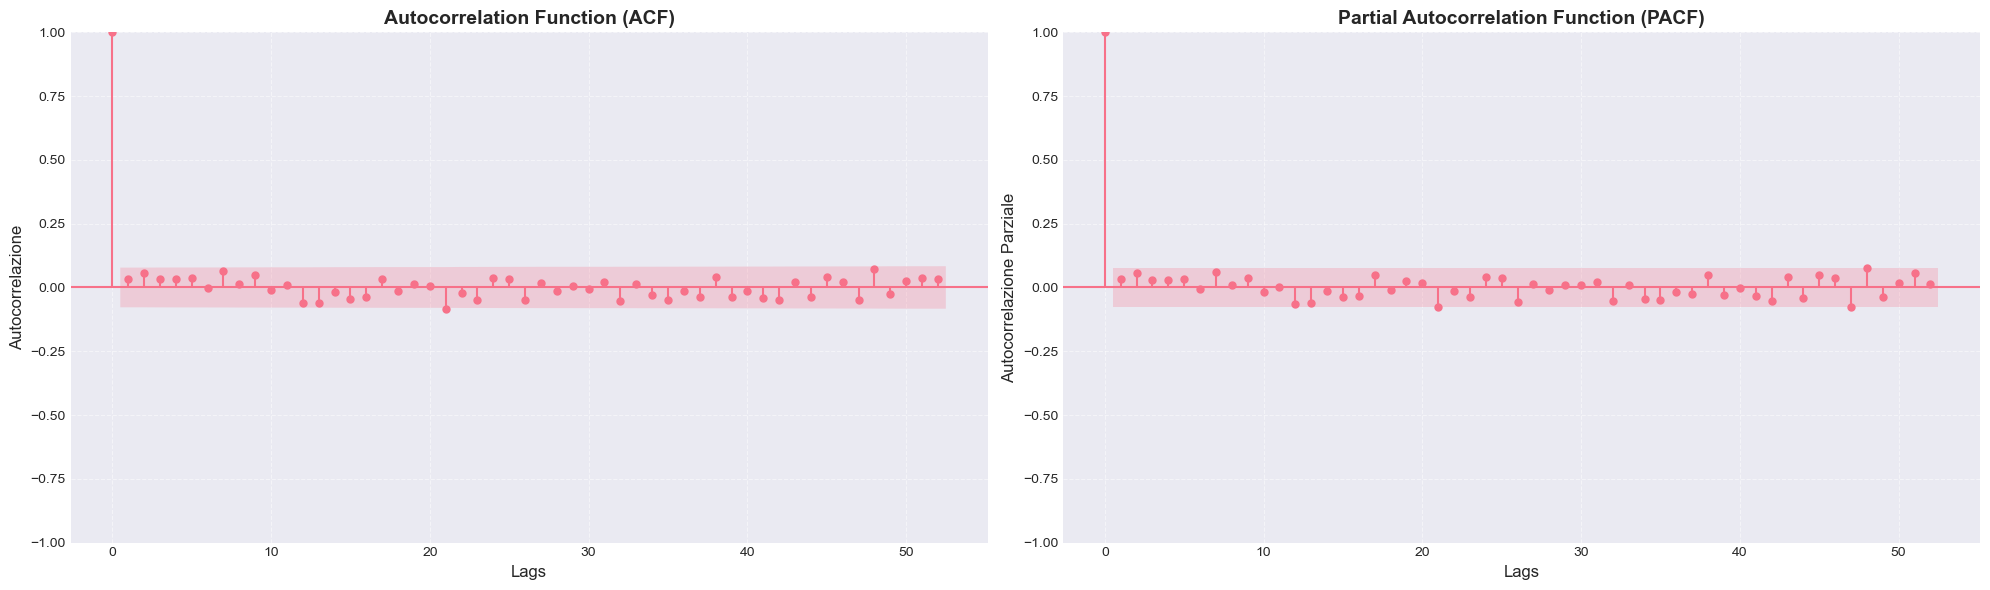

💡 INTERPRETAZIONE:
   • ACF decay lento → presenza di trend/non-stazionarietà
   • PACF con picchi significativi → componente AR
   • Picchi multipli di 52 → forte stagionalità annuale



In [28]:
print("\n" + "="*80)
print("FASE 6: ANALISI ACF/PACF")
print("="*80 + "\n")

fig, axes = plt.subplots(1, 2, figsize=(20, 6), dpi=100)

# ACF
plot_acf(df_east['respiratory_admissions'], lags=52, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Lags', fontsize=12)
axes[0].set_ylabel('Autocorrelazione', fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.5)

# PACF
plot_pacf(df_east['respiratory_admissions'], lags=52, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Lags', fontsize=12)
axes[1].set_ylabel('Autocorrelazione Parziale', fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print("💡 INTERPRETAZIONE:")
print("   • ACF decay lento → presenza di trend/non-stazionarietà")
print("   • PACF con picchi significativi → componente AR")
print("   • Picchi multipli di 52 → forte stagionalità annuale\n")

- ACF: L'ACF mostra la correlazione della serie con i propri valori passati a vari ritardi (lags). A differenza di una serie con forte stagionalità, qui non si osserva alcun pattern sinusoidale né picchi significativi ricorrenti (ad esempio al lag 52). Quasi tutti i lag successivi allo zero cadono ampiamente all'interno della fascia rosa (l'intervallo di confidenza al 95%). Questo indica che non vi è una memoria a lungo termine o un ciclo stagionale residuo evidente nella serie analizzata.

- PACF: La PACF isola la correlazione diretta tra i lag, eliminando l'influenza dei passaggi intermedi. In questo grafico, il Lag 1 è estremamente basso (vicino allo zero) e non mostra il "taglio netto" tipico dei processi autoregressivi forti. La quasi totalità dei punti fluttua casualmente all'interno dell'area di confidenza rosa, suggerendo che i valori correnti non dipendono in modo significativo dai valori immediatamente precedenti.
- Interpretazione: Quando sia l'ACF che la PACF mostrano valori che rientrano quasi interamente nell'intervallo di confidenza subito dopo il lag 0, siamo di fronte a una serie che non presenta più strutture AR (Autoregressive) o MA (Moving Average) rilevanti. Dal punto di vista della modellizzazione, questo suggerisce che non c'è ulteriore informazione sistematica da estrarre: la serie è già stata correttamente differenziata o filtrata, lasciando solo una componente stocastica imprevedibile.

In [31]:
print("="*80)
print("FASE 7: RICERCA PARAMETRI OTTIMALI (AUTO_ARIMA)")
print("="*80 + "\n")

print("🔍 Ricerca in corso (può richiedere 2-3 minuti)...\n")

sarima_model = pm.auto_arima(
    df_east['respiratory_admissions'],
    seasonal=True,
    m=52,
    d=None,  # Differenziazione semplice
    D=None,  # Differenziazione stagionale
    start_p=0, start_q=0,
    start_P=0, start_Q=0,
    max_p=2, max_q=2,
    max_P=2, max_Q=2,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    information_criterion='aic'
)

print("\n" + "─"*80)
print("MODELLO OTTIMALE TROVATO")
print("─"*80 + "\n")
print(sarima_model.summary())

best_order = sarima_model.order
best_seasonal = sarima_model.seasonal_order

print(f"\n✓ Parametri ottimali: SARIMA{best_order} × {best_seasonal}\n")



FASE 7: RICERCA PARAMETRI OTTIMALI (AUTO_ARIMA)

🔍 Ricerca in corso (può richiedere 2-3 minuti)...

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=3241.056, Time=0.01 sec


c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed 

 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=3243.605, Time=3.56 sec


c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=3243.669, Time=1.50 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=4774.524, Time=0.02 sec


c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(1,0,0)[52] intercept   : AIC=3242.317, Time=2.78 sec


c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,0,1)[52] intercept   : AIC=3242.311, Time=1.13 sec


c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(1,0,1)[52] intercept   : AIC=3244.312, Time=5.07 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=3242.334, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[52] intercept   : AIC=3242.408, Time=0.09 sec


c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[52] intercept   : AIC=3240.939, Time=0.61 sec


c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,0,0)[52] intercept   : AIC=3243.373, Time=8.12 sec


c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,1)[52] intercept   : AIC=3242.443, Time=6.16 sec


c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,0,1)[52] intercept   : AIC=3247.707, Time=5.79 sec
 ARIMA(2,0,1)(0,0,0)[52] intercept   : AIC=3244.179, Time=0.08 sec


c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[52] intercept   : AIC=3242.541, Time=0.43 sec
 ARIMA(0,0,2)(0,0,0)[52] intercept   : AIC=3242.473, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[52] intercept   : AIC=3242.239, Time=0.07 sec


c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[52] intercept   : AIC=3244.734, Time=0.51 sec
 ARIMA(1,0,1)(0,0,0)[52]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,0,1)(0,0,0)[52] intercept
Total fit time: 36.208 seconds

────────────────────────────────────────────────────────────────────────────────
MODELLO OTTIMALE TROVATO
────────────────────────────────────────────────────────────────────────────────

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  635
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1616.469
Date:                Mon, 16 Feb 2026   AIC                           3240.939
Time:                        17:54:18   BIC                           3258.753
Sample:                             0   HQIC                          3247.856
                                - 635                                         
Covariance Type:                  opg             

c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


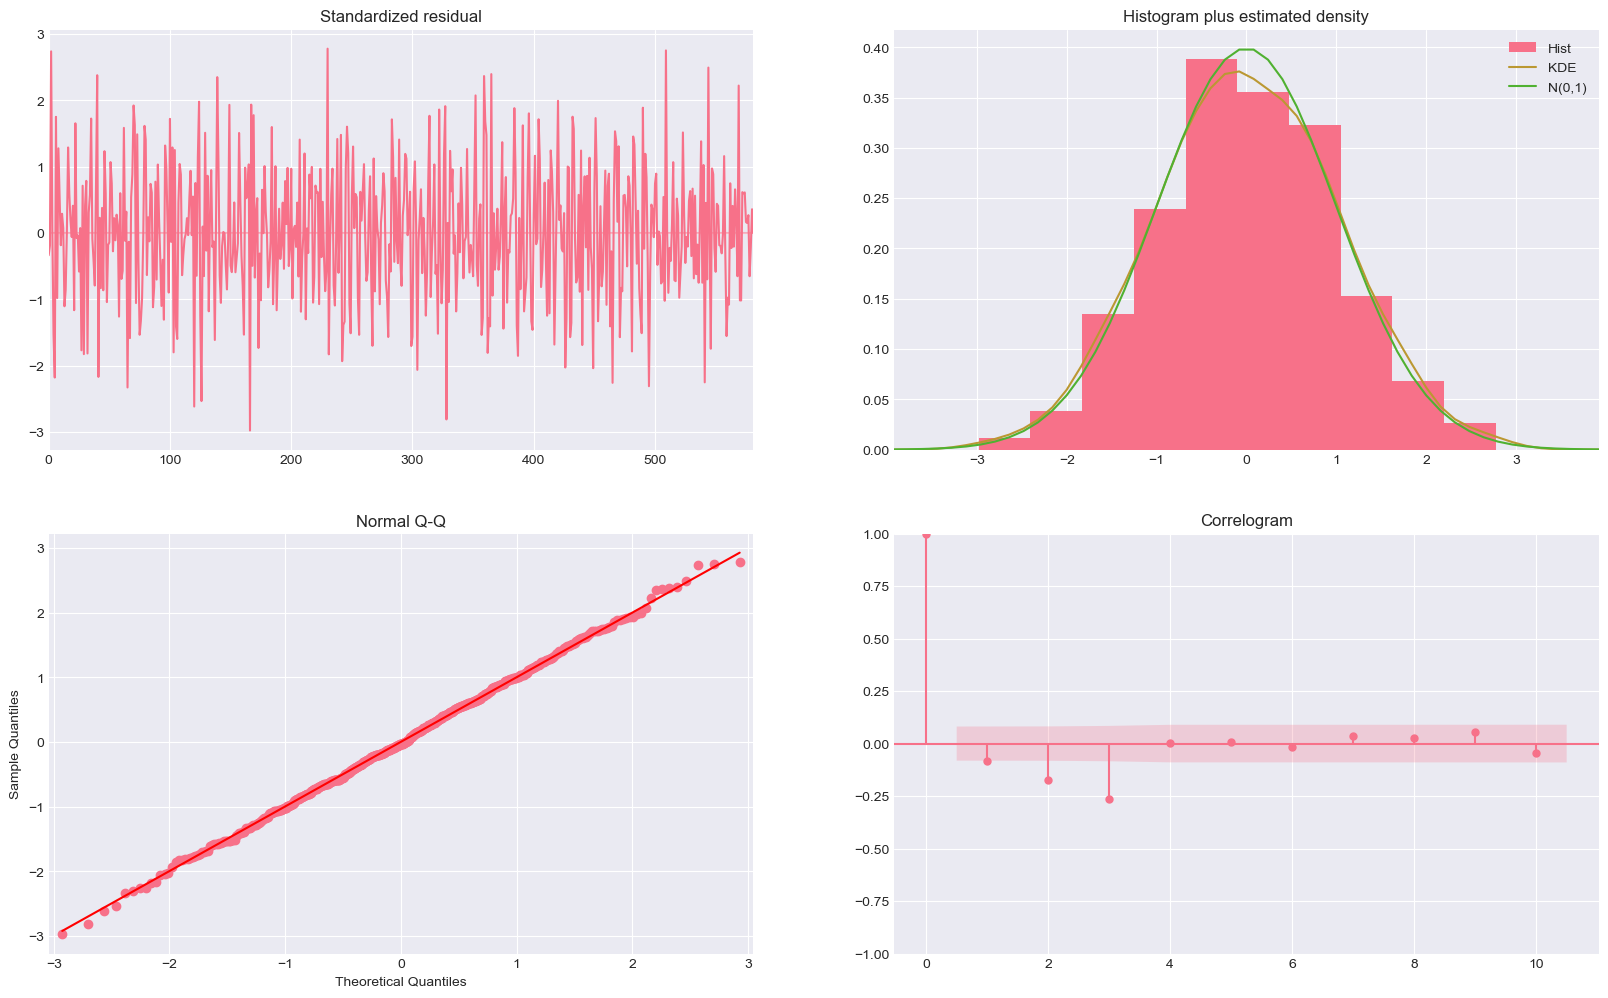

In [30]:
# Diagnostica del modello SARIMA
sarima_model.plot_diagnostics(figsize=(20, 12));

# Addestramento modello

In [25]:
print("="*80)
print("FASE 8: TRAIN/TEST SPLIT")
print("="*80 + "\n")

train_size = int(len(df_east) * 0.8)
train = df_east[:train_size]
test = df_east[train_size:]

print(f"📊 Training set:  {train.index[0]} → {train.index[-1]} ({len(train)} giorni)")
print(f"📊 Test set:      {test.index[0]} → {test.index[-1]} ({len(test)} giorni)")
print(f"   Split:         {len(train)/len(df_east)*100:.1f}% / {len(test)/len(df_east)*100:.1f}%\n")


FASE 8: TRAIN/TEST SPLIT

📊 Training set:  2020-01-01 00:00:00 → 2021-08-02 00:00:00 (508 giorni)
📊 Test set:      2021-08-03 00:00:00 → 2021-12-30 00:00:00 (127 giorni)
   Split:         80.0% / 20.0%



c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:             respiratory_admissions   No. Observations:                  508
Model:             SARIMAX(2, 0, 0)x(2, 0, 0, 52)   Log Likelihood               -1294.573
Date:                            Mon, 16 Feb 2026   AIC                           2601.145
Time:                                    18:18:19   BIC                           2626.528
Sample:                                         0   HQIC                          2611.099
                                            - 508                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      9.7725      0.935     10.448      0.000       7.939      11.606
ar.L1          0.0218      0.047   

c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


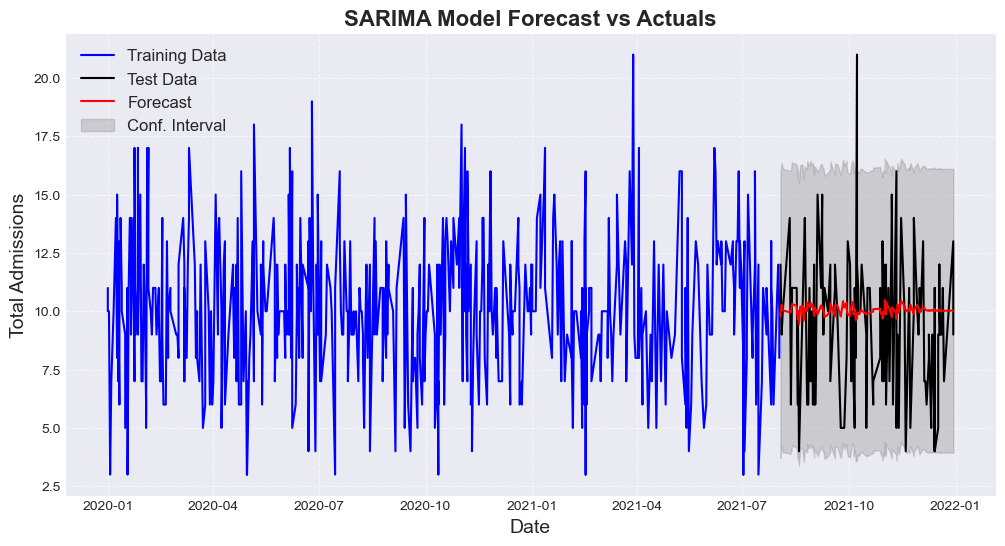

In [38]:
# 1. Definizione e Fit del modello
model = SARIMAX(train['respiratory_admissions'], 
                order=(2, 0, 0), 
                seasonal_order=(2, 0, 0, 52),
                trend='c')
model_fit = model.fit(disp=False)

# Stampa il riepilogo per controllare la significatività dei coefficienti
print(model_fit.summary())

# 2. Previsioni sul test set
forecast_object = model_fit.get_forecast(steps=len(test))
forecast_mean = forecast_object.predicted_mean
forecast_ci = forecast_object.conf_int()

# 3. Calcolo degli errori
mse = mean_squared_error(test['respiratory_admissions'], forecast_mean)
mae = mean_absolute_error(test['respiratory_admissions'], forecast_mean)
rmse = np.sqrt(mse)

print(f'\nMean Absolute Error (MAE): {mae:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

# 4. Plot dei risultati (Corretto con .index)
plt.figure(figsize=(12, 6))

# Usiamo .index perché la data è l'indice del dataframe
plt.plot(train.index, train['respiratory_admissions'], label='Training Data', color='blue')
plt.plot(test.index, test['respiratory_admissions'], label='Test Data', color='black')
plt.plot(test.index, forecast_mean, label='Forecast', color='red')

# L'intervallo di confidenza deve seguire l'indice del test set
plt.fill_between(test.index, 
                 forecast_ci.iloc[:, 0], 
                 forecast_ci.iloc[:, 1], label='Conf. Interval', color='grey', alpha=0.3)

plt.title('SARIMA Model Forecast vs Actuals', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Admissions', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Analisi serie differenziata

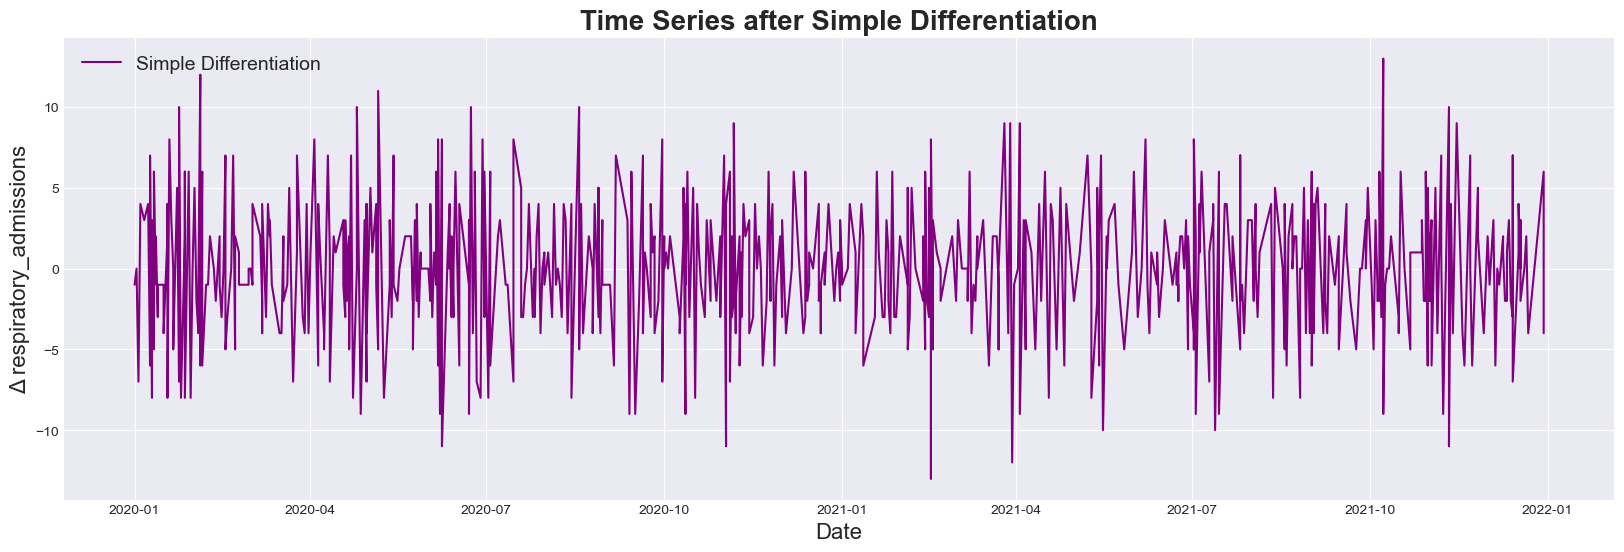

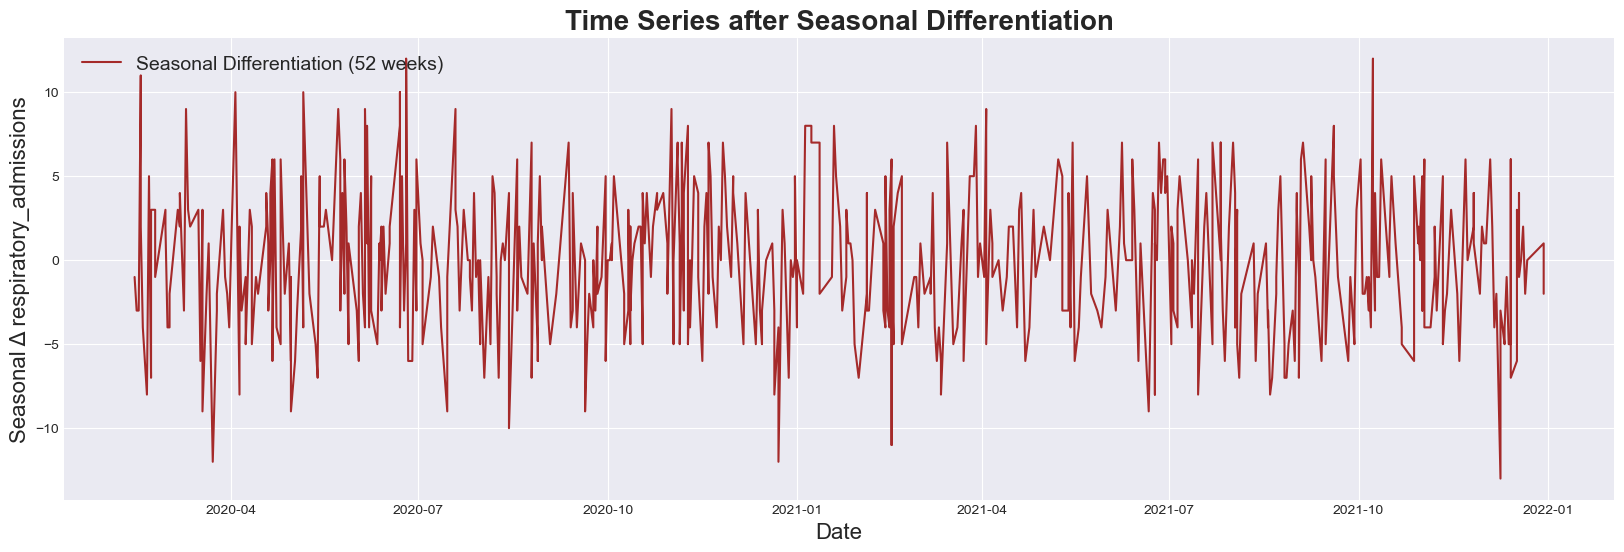


=== Risultati del test di stazionarietà ADF sulla serie differenziata semplice ===
ADF Test Statistic       -9.714015e+00
p-value                   9.940693e-17
Used Lag                  1.800000e+01
Number of Observations    6.150000e+02
Critical Value (1%)      -3.441028e+00
Critical Value (5%)      -2.866251e+00
Critical Value (10%)     -2.569279e+00
dtype: float64

=== Risultati del test di stazionarietà ADF sulla serie differenziata stagionale ===
ADF Test Statistic        -23.228092
p-value                     0.000000
Used Lag                    0.000000
Number of Observations    582.000000
Critical Value (1%)        -3.441636
Critical Value (5%)        -2.866519
Critical Value (10%)       -2.569422
dtype: float64


In [54]:
# Differenziazione semplice
admission_diff = df_east['respiratory_admissions'].diff().dropna()

# Differenziazione stagionale (period=52 settimane)
admission_seasonal_diff = df_east['respiratory_admissions'].diff(52).dropna()

# Grafico della differenziazione semplice
plt.figure(figsize=(20, 6))
plt.plot(admission_diff, label='Simple Differentiation', color='purple', linewidth=1.5)
plt.title('Time Series after Simple Differentiation', fontsize=20, fontweight='bold')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Δ respiratory_admissions', fontsize=16)
plt.legend(fontsize=14, loc='upper left')
plt.grid(True)
plt.show()

# Grafico della differenziazione stagionale
plt.figure(figsize=(20, 6))
plt.plot(admission_seasonal_diff, label='Seasonal Differentiation (52 weeks)', color='brown', linewidth=1.5)
plt.title('Time Series after Seasonal Differentiation', fontsize=20, fontweight='bold')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Seasonal Δ respiratory_admissions', fontsize=16)
plt.legend(fontsize=14, loc='upper left')
plt.grid(True)
plt.show()

# Test di stazionarietà ADF sulla serie differenziata
adf_test_diff = adfuller(admission_diff)
adf_test_seasonal_diff = adfuller(admission_seasonal_diff)
adf_results_diff = pd.Series({"ADF Test Statistic": adf_test_diff[0],
                         "p-value": adf_test_diff[1],
                         "Used Lag": adf_test_diff[2],
                         "Number of Observations": adf_test_diff[3],
                         "Critical Value (1%)": adf_test_diff[4]['1%'],
                         "Critical Value (5%)": adf_test_diff[4]['5%'],
                         "Critical Value (10%)": adf_test_diff[4]['10%']})

adf_results_seasonal_diff = pd.Series({"ADF Test Statistic": adf_test_seasonal_diff[0],
                         "p-value": adf_test_seasonal_diff[1],
                         "Used Lag": adf_test_seasonal_diff[2],
                         "Number of Observations": adf_test_seasonal_diff[3],
                         "Critical Value (1%)": adf_test_seasonal_diff[4]['1%'],
                         "Critical Value (5%)": adf_test_seasonal_diff[4]['5%'],
                         "Critical Value (10%)": adf_test_seasonal_diff[4]['10%']})
print("\n=== Risultati del test di stazionarietà ADF sulla serie differenziata semplice ===")
print(adf_results_diff)
print("\n=== Risultati del test di stazionarietà ADF sulla serie differenziata stagionale ===")
print(adf_results_seasonal_diff)

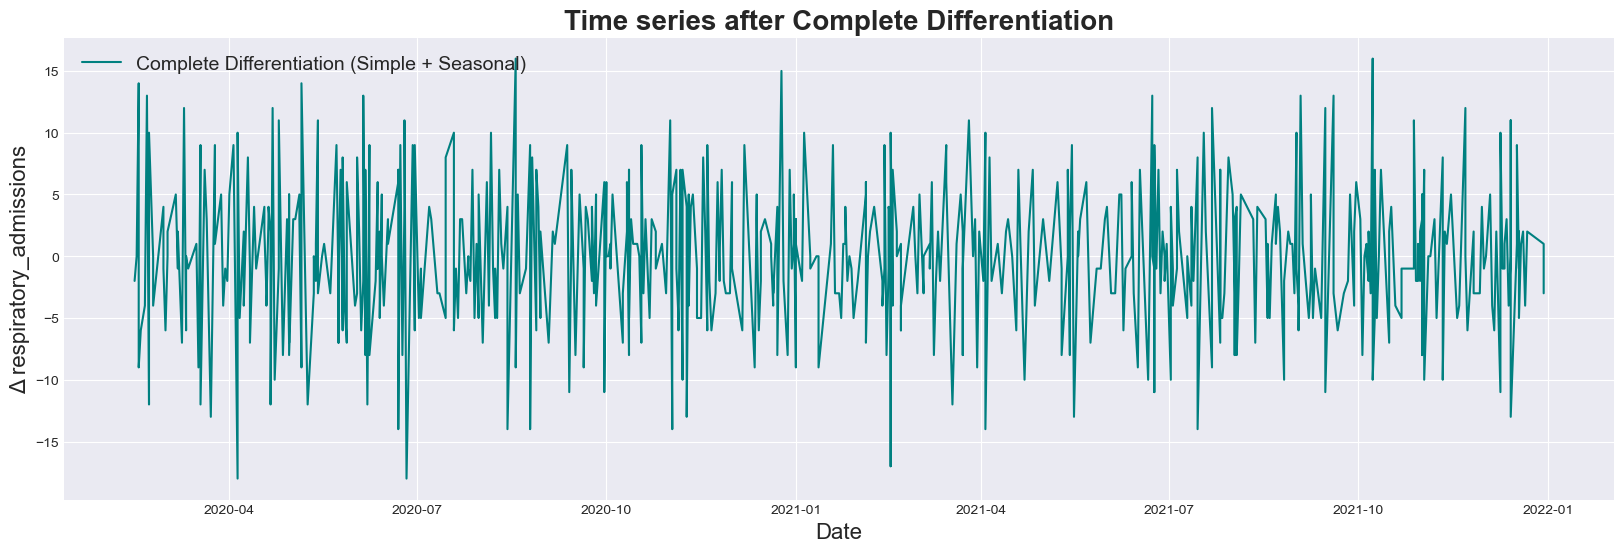

In [43]:
# Differenziazione completa (semplice + stagionale)
admission_full_diff = df_east['respiratory_admissions'].diff().diff(52).dropna()

# Grafico della differenziazione completa
plt.figure(figsize=(20, 6))
plt.plot(admission_full_diff, label='Complete Differentiation (Simple + Seasonal)', color='teal', linewidth=1.5)
plt.title('Time series after Complete Differentiation', fontsize=20, fontweight='bold')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Δ respiratory_admissions', fontsize=16)
plt.legend(fontsize=14, loc='upper left')
plt.grid(True)
plt.show()

In [44]:
# Test di stazionarietà ADF sulla serie completamente differenziata
adf_test_diff_full = adfuller(admission_full_diff)

# Risultati del test ADF
adf_results_diff_full = pd.Series({"ADF Test Statistic": adf_test_diff_full[0],
                         "p-value": adf_test_diff_full[1],
                         "Used Lag": adf_test_diff_full[2],
                         "Number of Observations": adf_test_diff_full[3],
                         "Critical Value (1%)": adf_test_diff_full[4]['1%'],
                         "Critical Value (5%)": adf_test_diff_full[4]['5%'],
                         "Critical Value (10%)": adf_test_diff_full[4]['10%']})

print("\n=== Risultati del test di stazionarietà ADF sulla serie completamente differenziata ===")
print(adf_results_diff_full)


=== Risultati del test di stazionarietà ADF sulla serie completamente differenziata ===
ADF Test Statistic       -9.448485e+00
p-value                   4.685248e-16
Used Lag                  1.800000e+01
Number of Observations    5.630000e+02
Critical Value (1%)      -3.442019e+00
Critical Value (5%)      -2.866687e+00
Critical Value (10%)     -2.569511e+00
dtype: float64


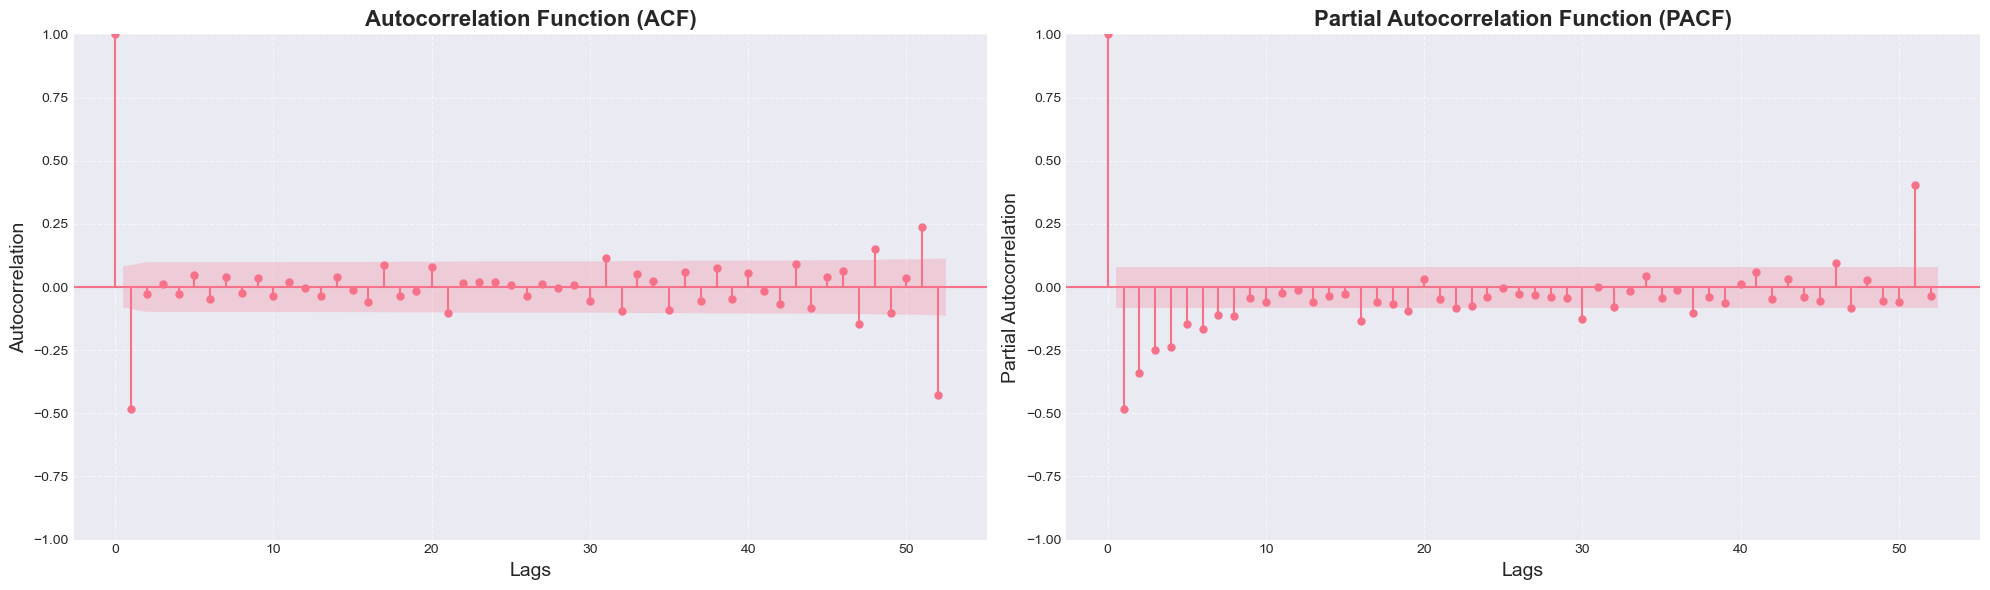

In [45]:
# Creazione dei grafici ACF e PACF
fig, axes = plt.subplots(1, 2, figsize=(20, 6), dpi = 100)

# Grafico ACF
plot_acf(admission_full_diff, lags=52, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Lags', fontsize=14)
axes[0].set_ylabel('Autocorrelation', fontsize=14)
axes[0].grid(True, linestyle='--', alpha=0.6)

# Grafico PACF
plot_pacf(admission_full_diff, lags=52, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Lags', fontsize=14)
axes[1].set_ylabel('Partial Autocorrelation', fontsize=14)
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [46]:
# Eseguiamo auto_arima specificando il periodo stagionale 'm'
# e forzando la differenziazione semplice e stagionale.
sarima_model = pm.auto_arima(
    df_east['respiratory_admissions'],  # La serie temporale
    seasonal=True,                         # Abilita la ricerca di un modello stagionale
    m=52,                                  # Il periodo a 52 settimane
    
    # Parametri per guidare la ricerca
    d=1,                                   # Forza una differenziazione semplice (per il trend)
    D=1,                                   # Forza una differenziazione stagionale
    start_p=0, start_q=0,                  # Punto di partenza per i parametri non stagionali
    start_P=0, start_Q=0,                  # Punto di partenza per i parametri stagionali
    max_p=2, max_q=2,                      # Limite massimo per p e q
    max_P=2, max_Q=2,                      # Limite massimo per P e Q

    # Parametri per il controllo del processo
    trace=True,                            # Mostra i modelli che sta testando
    error_action='ignore',                 # Ignora i modelli che non convergono
    suppress_warnings=True,                # Sopprime i warning
    stepwise=True                          # Usa un approccio efficiente per la ricerca
)

# Stampa il sommario del modello migliore trovato
print(sarima_model.summary())

c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=3727.326, Time=0.20 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=3432.271, Time=1.47 sec


c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=8.06 sec


c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,1,0)[52]             : AIC=3574.785, Time=0.46 sec


c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,0)[52]             : AIC=inf, Time=6.84 sec


c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,1)[52]             : AIC=inf, Time=20.49 sec


c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,1,1)[52]             : AIC=inf, Time=11.85 sec


c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,1)[52]             : AIC=inf, Time=25.61 sec


c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,1,0)[52]             : AIC=3594.443, Time=1.57 sec


c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,1,0)[52]             : AIC=3376.049, Time=2.67 sec


c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,1,0)[52]             : AIC=3505.636, Time=0.82 sec


c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,1,0)[52]             : AIC=inf, Time=6.44 sec


c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,1,1)[52]             : AIC=inf, Time=19.31 sec


c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,1,1)[52]             : AIC=inf, Time=8.77 sec


c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,1,1)[52]             : AIC=inf, Time=28.42 sec


c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,1,0)[52]             : AIC=inf, Time=32.71 sec


c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,1,0)[52]             : AIC=inf, Time=23.68 sec


c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,1,0)[52] intercept   : AIC=3378.048, Time=8.37 sec

Best model:  ARIMA(2,1,0)(1,1,0)[52]          
Total fit time: 207.796 seconds
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  635
Model:             SARIMAX(2, 1, 0)x(1, 1, 0, 52)   Log Likelihood               -1684.025
Date:                            Mon, 16 Feb 2026   AIC                           3376.049
Time:                                    19:24:03   BIC                           3393.515
Sample:                                         0   HQIC                          3382.858
                                            - 635                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------

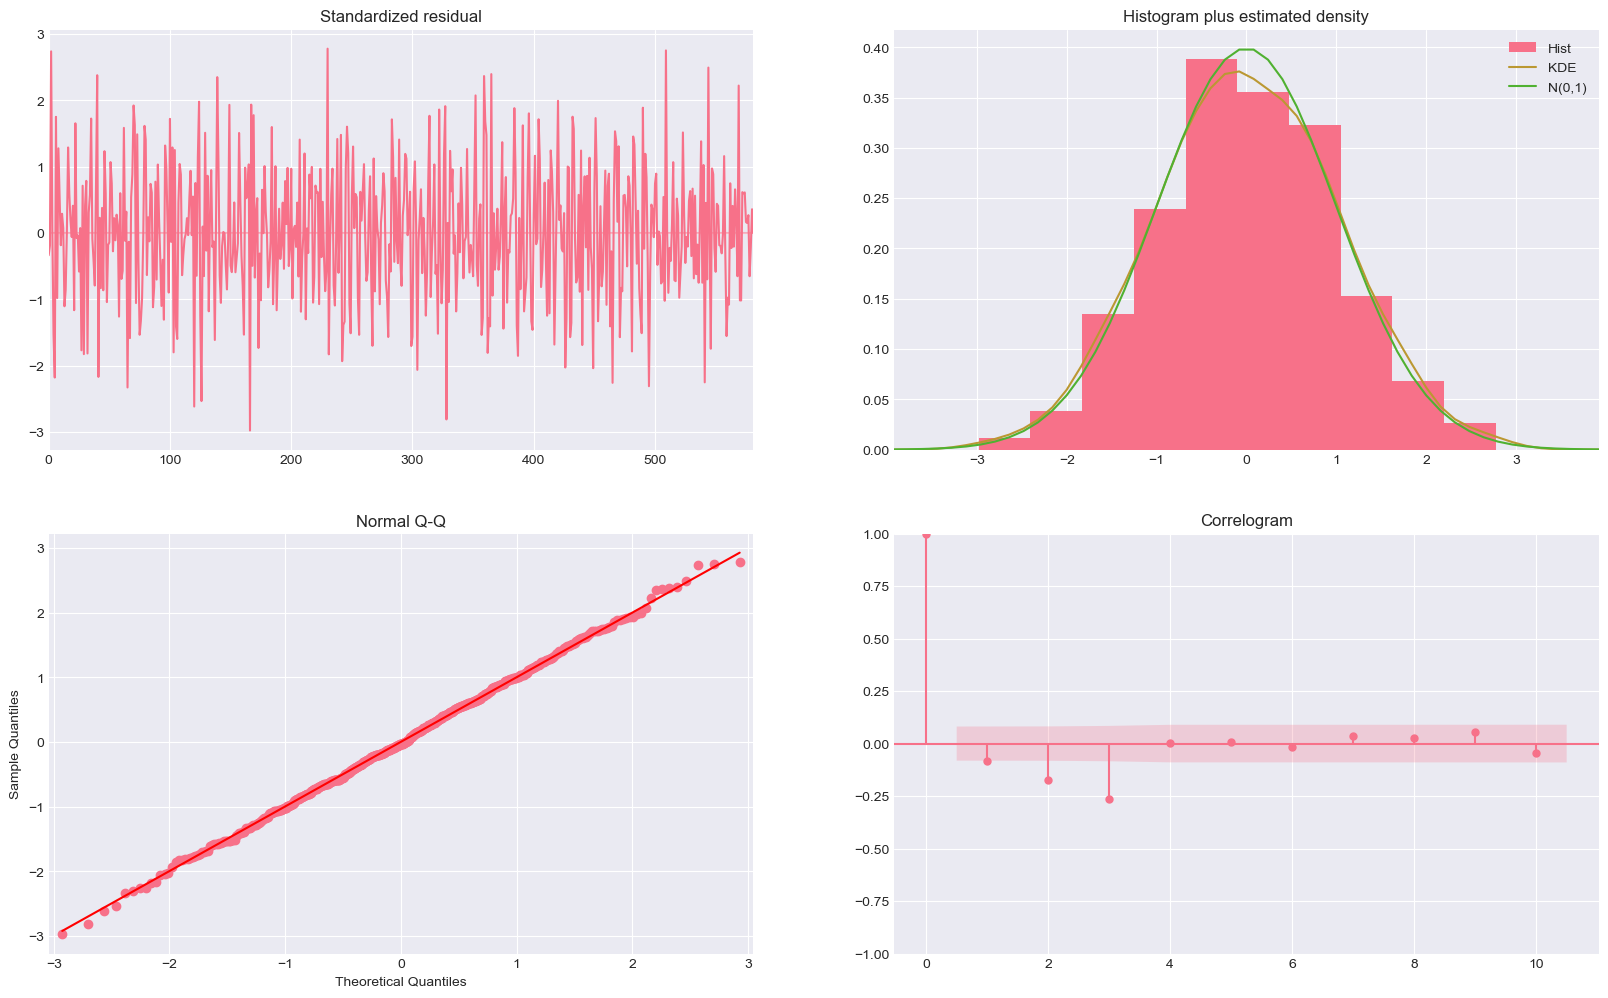

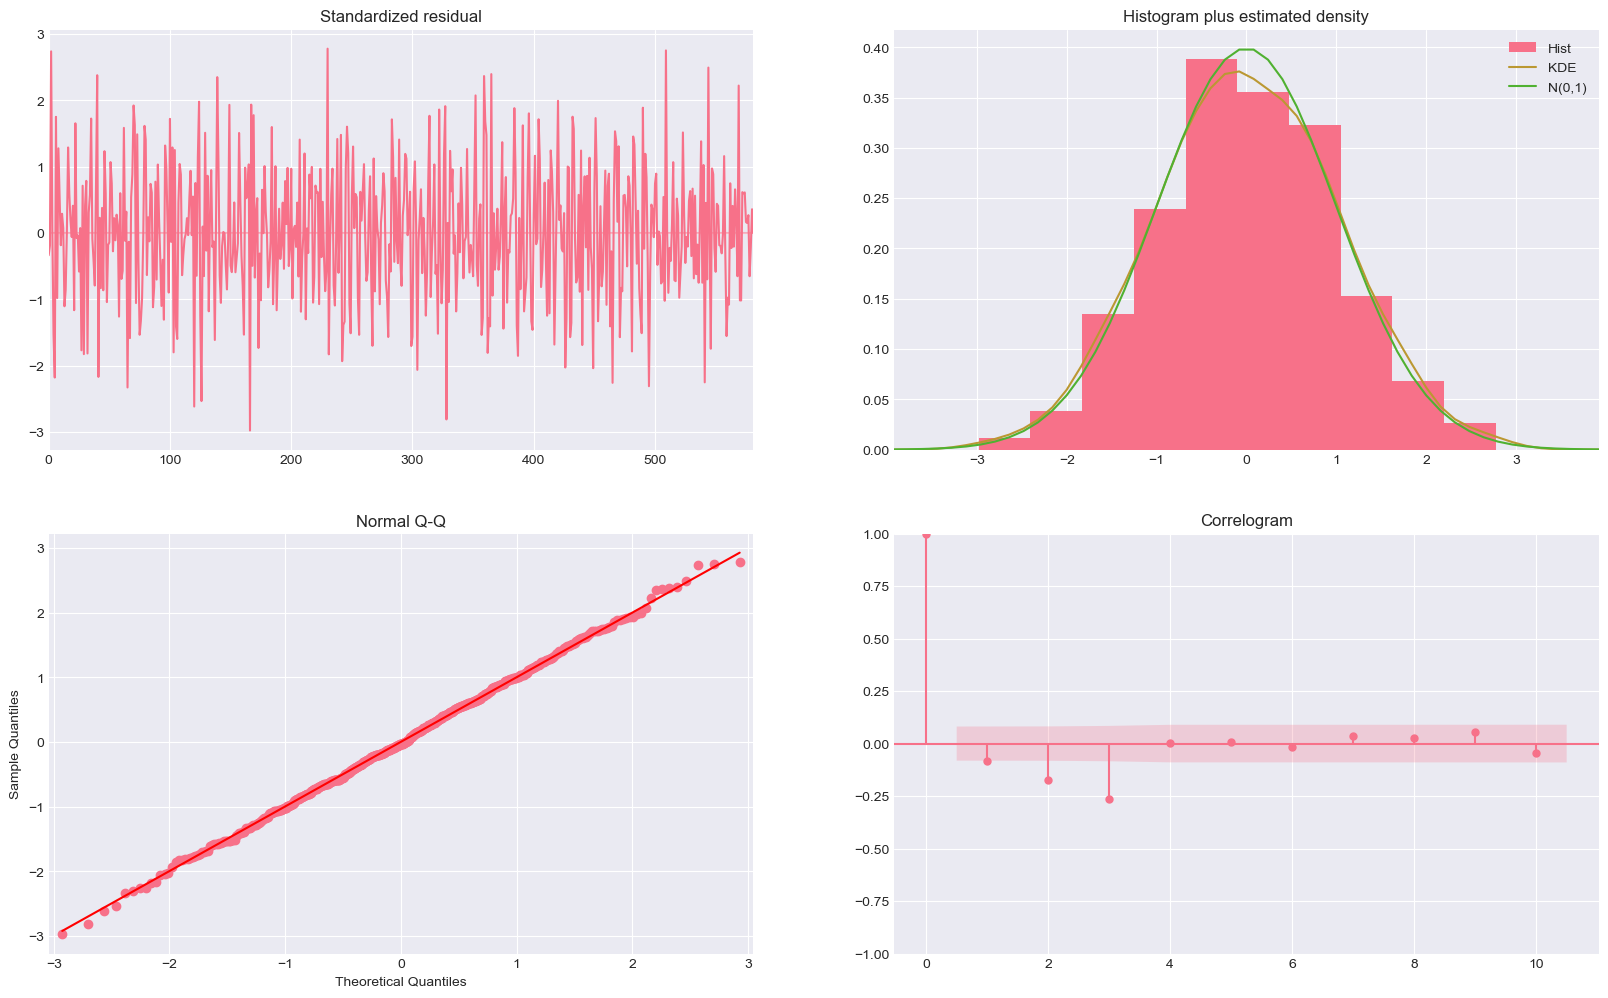

In [49]:
# Diagnostica del modello SARIMA
sarima_model.plot_diagnostics(figsize=(20, 12))

c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:              respiratory_admissions   No. Observations:                  508
Model:             SARIMAX(1, 1, 1)x(2, 1, [], 52)   Log Likelihood               -1241.001
Date:                             Mon, 16 Feb 2026   AIC                           2492.001
Time:                                     19:28:53   BIC                           2512.603
Sample:                                          0   HQIC                          2500.117
                                             - 508                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0214      0.048      0.447      0.655      -0.073       0.116
ma.L1         -0.9999      

c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


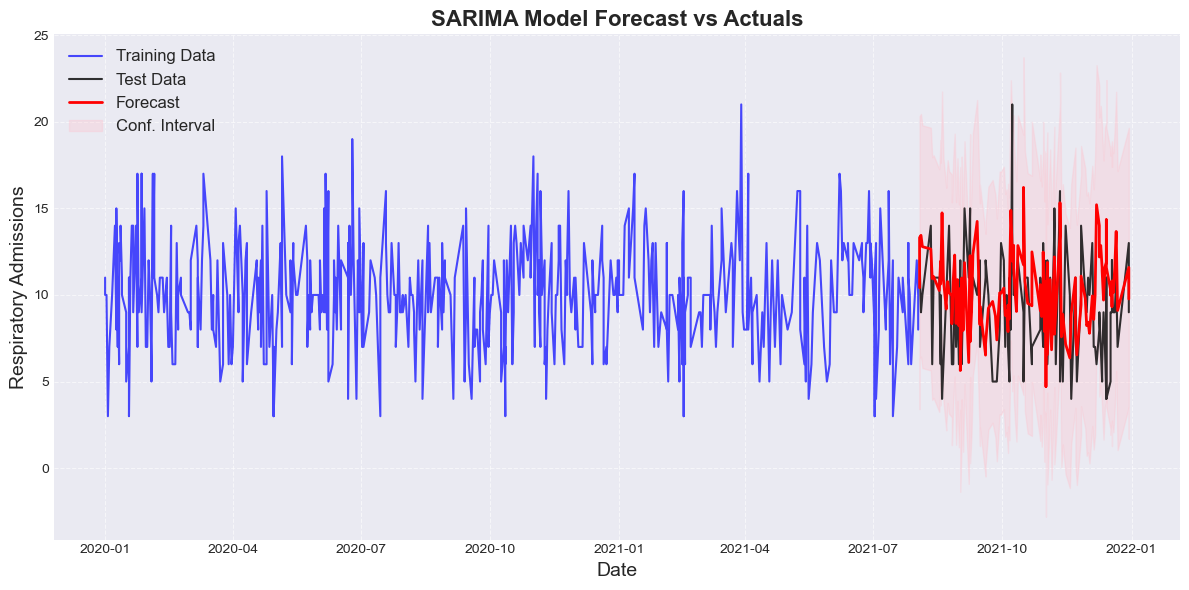

In [50]:
# 1. Divisione in training e test set
train_size = int(len(df_east) * 0.8)
train = df_east.iloc[:train_size]
test = df_east.iloc[train_size:]

# 2. Addestramento del modello SARIMA
# Nota: d=1 e D=1 indicano che stai applicando le differenziazioni viste nel codice precedente
model = SARIMAX(train['respiratory_admissions'], 
                order=(1, 1, 1), 
                seasonal_order=(2, 1, 0, 52),
                trend='n') # 'n' sta per nessun trend costante, corretto se hai differenziato
model_fit = model.fit(disp=False)

# Stampa il riepilogo statistico
print(model_fit.summary())

# 3. Previsioni sul test set
forecast_object = model_fit.get_forecast(steps=len(test))
forecast_mean = forecast_object.predicted_mean
forecast_ci = forecast_object.conf_int()

# 4. Calcolo degli errori
mse = mean_squared_error(test['respiratory_admissions'], forecast_mean)
mae = mean_absolute_error(test['respiratory_admissions'], forecast_mean)
rmse = np.sqrt(mse)

print(f'\n--- Metriche di Errore ---')
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

# 5. Plot dei risultati
plt.figure(figsize=(12, 6))

# Usiamo .index perché le date sono nell'indice del DataFrame
plt.plot(train.index, train['respiratory_admissions'], label='Training Data', color='blue', alpha=0.7)
plt.plot(test.index, test['respiratory_admissions'], label='Test Data', color='black', alpha=0.8)
plt.plot(test.index, forecast_mean, label='Forecast', color='red', linewidth=2)

# Intervallo di confidenza
plt.fill_between(test.index, 
                 forecast_ci.iloc[:, 0], 
                 forecast_ci.iloc[:, 1], color='pink', alpha=0.3, label='Conf. Interval')

plt.title('SARIMA Model Forecast vs Actuals', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Respiratory Admissions', fontsize=14)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:              respiratory_admissions   No. Observations:                  508
Model:             SARIMAX(1, 1, 1)x(2, 1, [], 52)   Log Likelihood               -1238.690
Date:                             Mon, 16 Feb 2026   AIC                           2491.380
Time:                                     19:35:23   BIC                           2520.222
Sample:                                          0   HQIC                          2502.743
                                             - 508                                         
Covariance Type:                               opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
PM2.5           0.0188      0.009      1.994      0.046       0.000       0.037
temperature     0.0207  

c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Asus\miniconda3\envs\DataScience\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


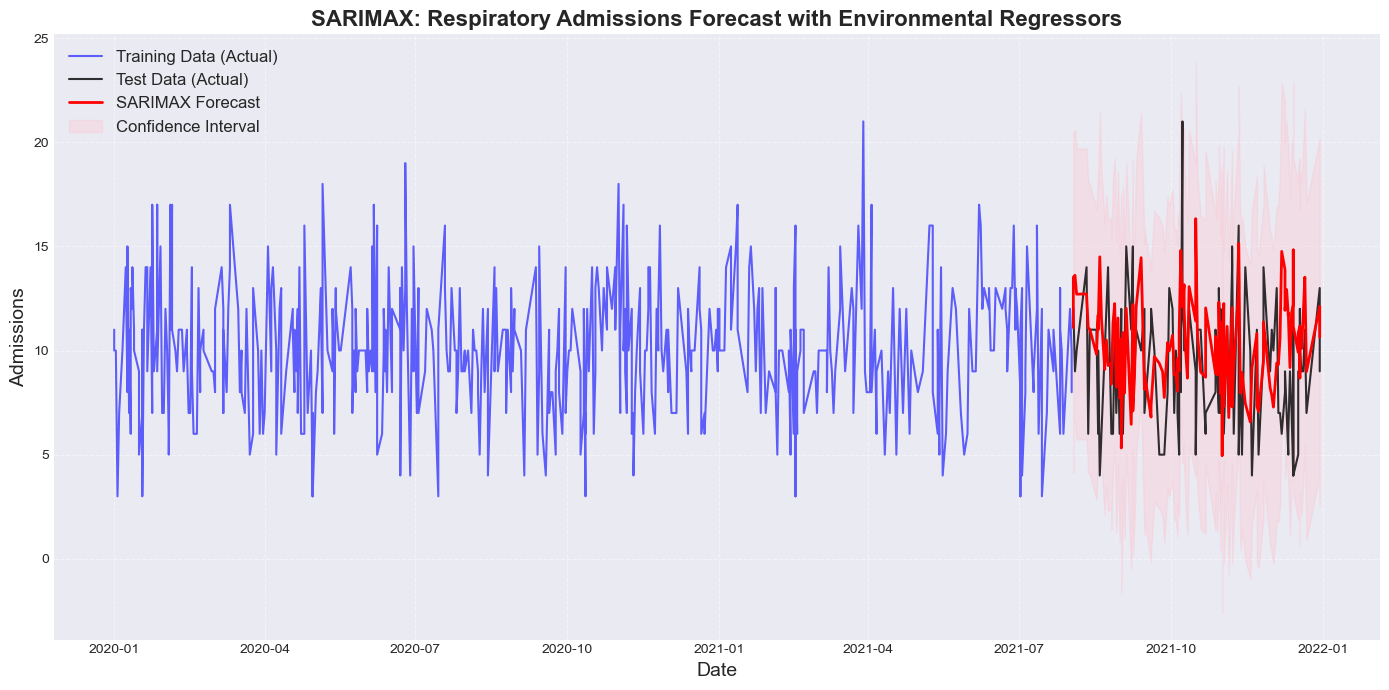

In [52]:
# Definiamo la variabile target (y) e le variabili esogene (X)
y = df_east['respiratory_admissions']
exog_vars = ['PM2.5', 'temperature']
X = df_east[exog_vars]

# 2. DIVISIONE IN TRAINING E TEST SET (80/20)
train_size = int(len(df_east) * 0.8)

train_y, test_y = y.iloc[:train_size], y.iloc[train_size:]
train_X, test_X = X.iloc[:train_size], X.iloc[train_size:]

# 3. ADDESTRAMENTO DEL MODELLO SARIMAX
# Usiamo i parametri identificati per gestire stazionarietà (d=1) e stagionalità (D=1)
model_exog = SARIMAX(
    train_y,
    exog=train_X,
    order=(1, 1, 1),              # (p, d, q)
    seasonal_order=(2, 1, 0, 52), # (P, D, Q, s)
    trend='n'                     # Nessun trend costante perché abbiamo differenziato
)

model_exog_fit = model_exog.fit(disp=False)

# Visualizzazione dei risultati statistici
print(model_exog_fit.summary())

# 4. PREVISIONI SUL TEST SET
# Importante: passiamo test_X come variabili esogene per il futuro
forecast_object = model_exog_fit.get_forecast(steps=len(test_y), exog=test_X)
forecast_mean = forecast_object.predicted_mean
forecast_ci = forecast_object.conf_int()

# 5. CALCOLO DELLE METRICHE DI ERRORE
mse = mean_squared_error(test_y, forecast_mean)
mae = mean_absolute_error(test_y, forecast_mean)
rmse = np.sqrt(mse)

print(f'\n--- PERFORMANCE DEL MODELLO ---')
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

# 6. PLOT DEI RISULTATI
plt.figure(figsize=(14, 7))

# Dati storici (Training)
plt.plot(train_y.index, train_y, label='Training Data (Actual)', color='blue', alpha=0.6)

# Dati reali del test set
plt.plot(test_y.index, test_y, label='Test Data (Actual)', color='black', alpha=0.8)

# Previsione del modello
plt.plot(test_y.index, forecast_mean, label='SARIMAX Forecast', color='red', linewidth=2)

# Intervallo di confidenza
plt.fill_between(test_y.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 label='Confidence Interval',
                 color='pink', alpha=0.3)

plt.title('SARIMAX: Respiratory Admissions Forecast with Environmental Regressors', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Admissions', fontsize=14)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()